In [26]:
from __future__ import annotations
import sys
import os
import pickle
from pathlib import Path
from datetime import datetime

sys.path.append(os.path.abspath("../.."))

import argparse
import math
import random
from pathlib import Path
from __future__ import annotations

from typing import Iterator, Tuple, List, Dict
from types import SimpleNamespace

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt

from vol_predict.models.mixture.tm_pred2 import (
    TM_N_Predictor,
    TM_LN_Predictor,
    TM_IG_Predictor,
    TM_W_Predictor,
    TM_HN_W_Predictor,
    TM_HN_IG_Predictor
)
from vol_predict.loss.tm_loss import (
    MixtureNormalNLL,
    HingeNormalMixtureNLL,
    MixtureLogNormalNLL,
    MixtureInverseGaussianNLL,
    MixtureWeibullNLL,
    GenericMixtureNLL,
    MixtureHingeNormalWeibullNLL,
    MixtureHingeNormalInvGaussianNLL
)


# --------------------------------------
# Saving
# ----------------------------------------

def save_model(model, model_type, strategy, step=None, interval=None):
    """
    Save trained model to disk
    
    Parameters:
    -----------
    model : nn.Module
        Trained PyTorch model
    model_type : str
        Name of the model type (e.g., 'normal', 'hinge', etc.)
    strategy : str
        Training strategy ('single', 'rolling', 'incremental', 'online', 'online_expanding')
    step : int, optional
        Step number for online strategies
    interval : int, optional
        Interval number for rolling/incremental strategies
    """
    # Create directory structure if it doesn't exist
    save_dir = Path(f"saved_models/{strategy}/{model_type}")
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Determine filename based on strategy
    if strategy in ["online", "online_expanding"]:
        filename = f"model_step_{step}.pt"
    elif strategy in ["rolling", "incremental"]:
        filename = f"model_interval_{interval}.pt"
    else:  # single
        filename = "model.pt"
    
    # Save the model
    torch.save(model.state_dict(), save_dir / filename)
    print(f"Model saved to {save_dir / filename}")

def save_residuals(residuals: Union[np.ndarray, Tuple[np.ndarray, np.ndarray]],
                  model_type: str,
                  strategy: str,
                  step: int = None,
                  interval: int = None):
    """
    Save model residuals to disk
    
    Parameters:
    -----------
    residuals : np.ndarray or Tuple[np.ndarray, np.ndarray]
        Array of prediction residuals or tuple of (scaled_residuals, original_residuals)
    model_type : str
        Name of the model type
    strategy : str
        Training strategy
    step : int, optional
        Step number for online strategies
    interval : int, optional
        Interval number for rolling/incremental strategies
    """
    # Create directory structure if it doesn't exist
    save_dir = Path(f"saved_residuals/{strategy}/{model_type}")
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Handle both old (single array) and new (tuple) formats
    if isinstance(residuals, tuple):
        scaled_residuals, original_residuals = residuals
    else:
        scaled_residuals, original_residuals = residuals, None
    
    # Determine filename based on strategy
    if strategy in ["online", "online_expanding"]:
        scaled_filename = f"scaled_residuals_step_{step}.npy"
        original_filename = f"original_residuals_step_{step}.npy"
    elif strategy in ["rolling", "incremental"]:
        scaled_filename = f"scaled_residuals_interval_{interval}.npy"
        original_filename = f"original_residuals_interval_{interval}.npy"
    else:  # single
        scaled_filename = "scaled_residuals.npy"
        original_filename = "original_residuals.npy"
    
    # Save the scaled residuals
    #np.save(save_dir / scaled_filename, scaled_residuals)
    #print(f"Scaled residuals saved to {save_dir / scaled_filename}")
    
    # Save the original scale residuals if available
    if original_residuals is not None:
        np.save(save_dir / original_filename, original_residuals)
        print(f"Original scale residuals saved to {save_dir / original_filename}")

def save_predictions(predictions, targets, model_type, strategy, step=None, interval=None):
    """
    Save model predictions and targets to disk
    
    Parameters:
    -----------
    predictions : np.ndarray
        Array of model predictions
    targets : np.ndarray
        Array of target values
    model_type : str
        Name of the model type
    strategy : str
        Training strategy
    step : int, optional
        Step number for online strategies
    interval : int, optional
        Interval number for rolling/incremental strategies
    """
    # Create directory structure if it doesn't exist
    save_dir = Path(f"saved_predictions/{strategy}/{model_type}")
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Determine filename based on strategy
    if strategy in ["online", "online_expanding"]:
        filename = f"predictions_step_{step}"
    elif strategy in ["rolling", "incremental"]:
        filename = f"predictions_interval_{interval}"
    else:  # single
        filename = "predictions"
    
    # Save the predictions
    data = {
        "predictions": predictions,
        "targets": targets
    }
    np.save(save_dir / f"{filename}.npy", data)
    print(f"Predictions saved to {save_dir / filename}.npy")


@torch.no_grad()
def get_predictions_and_targets(loader, model, device):
    """Return np.arrays of predictions and targets for all points in a DataLoader."""
    model.eval()
    preds, targets = [], []
    for vol_hist, feats, target in loader:
        vol_hist, feats = vol_hist.to(device), feats.to(device)
        roll_mean = vol_hist.mean(dim=1)
        out = model(vol_hist, feats, roll_mean=roll_mean)
        pred = out["mixture_mean"]
        preds.append(pred.cpu().numpy())
        targets.append(target.numpy())
    return np.concatenate(preds), np.concatenate(targets)


# --------------------------------------------------------------------------- #
#  Reproducibility                                                            #
# --------------------------------------------------------------------------- #
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # might slow down but ensures reproducibility
    torch.backends.cudnn.benchmark = False
    
set_seed()

# --------------------------------------------------------------------------- #
#  Data utilities                                                             #
# --------------------------------------------------------------------------- #
def preprocess_csv(csv_path: Path) -> pd.DataFrame:
    """
    Load, clean and standardise the raw CSV exactly as required.
    """
    data = pd.read_csv(csv_path)

    # --- drop unneeded columns ------------------------------------------------
    data.dropna(inplace=True)
    cols_to_drop = [c for c in data.columns if c.startswith("ask_depth_t")]
    data.drop(columns=cols_to_drop, inplace=True)
    cols_to_drop = [c for c in data.columns if c.startswith("ret")]
    data.drop(columns=cols_to_drop, inplace=True)
    data.drop(columns='datetime', inplace=True)

    return data

def winsorize_and_scale(df_base: pd.DataFrame,
                        rows: List[int],
                        thresh: float,
                        min_std: float = 1e-6) -> Tuple[pd.DataFrame, pd.Series, pd.Series]:

    df_w = df_base.iloc[rows].copy().clip(lower=-thresh, upper=thresh)
    mu    = df_w.mean()
    sigma = df_w.std().replace(0, 1)
    sigma[sigma < min_std] = min_std

    df_scaled = df_w.copy()
    feature_cols = [c for c in df_w.columns if c != "vol"]

    df_scaled[feature_cols] = (df_w[feature_cols] - mu[feature_cols]) / sigma[feature_cols]
    df_scaled["vol"] = df_w["vol"] / sigma["vol"]

    return df_scaled, mu, sigma
class TMDataset(Dataset):
    """Dataset producing (past_vol, features_flat, target_vol)."""

    def __init__(self, df: pd.DataFrame, ar_order: int = 16):
        super().__init__()
        self.ar_order = ar_order

        self.vol_array = df["vol"].values.astype(np.float32)
        self.feat_array = df.iloc[:, 1:].values.astype(np.float32)

        self.valid_idx = range(ar_order, len(df))

    def __len__(self) -> int:
        return len(self.valid_idx)

    def __getitem__(self, idx: int):
        i = self.valid_idx[idx]
        past_vol = self.vol_array[i - self.ar_order : i]           # [ar_order]
        feats = self.feat_array[i]                                 # [n*lb]
        target = self.vol_array[i]

        return (torch.tensor(past_vol, dtype=torch.float32),
                torch.tensor(feats, dtype=torch.float32),
                torch.tensor(target, dtype=torch.float32))


# --------------------------------------------------------------------------- #
#  Model / loss factory                                                       #
# --------------------------------------------------------------------------- #
def model_and_loss(model_type: str,
                   ar_order: int,
                   n: int,
                   lb: int,
                   penalty_coef: float = 1.0,
                   kl_weight: float = 0,
                   delta: float = 0.0,
                   l2_coef: float = 0.0,
                   eps: float = 1e-12) -> Tuple[nn.Module, nn.Module]:

    if model_type == "normal":
        model = TM_N_Predictor(ar_order, n, lb)
        loss = MixtureNormalNLL(eps=eps, l2_coef=l2_coef)
    elif model_type == "hinge":
        model = TM_N_Predictor(ar_order, n, lb)
        loss = HingeNormalMixtureNLL(
            penalty_coef=penalty_coef, delta=delta,
            eps=eps, l2_coef=l2_coef
        )
    elif model_type == "lognormal":
        model = TM_LN_Predictor(ar_order, n, lb)
        loss = GenericMixtureNLL(crps_weight=0.1,kl_weight = kl_weight, l2_coef=l2_coef)
        loss.set_model(model)
    elif model_type == "inverse_gaussian":
        model = TM_IG_Predictor(ar_order, n, lb)
        loss = GenericMixtureNLL(crps_weight=0.1,kl_weight = kl_weight, l2_coef=l2_coef)
        loss.set_model(model)
    elif model_type == "weibull":
        model = TM_W_Predictor(ar_order, n, lb)
        loss = GenericMixtureNLL(crps_weight=0.1, kl_weight = kl_weight, l2_coef=l2_coef)
        loss.set_model(model)
    elif model_type == "hinge_weibull":
        model = TM_HN_W_Predictor(ar_order, n, lb)
        loss = MixtureHingeNormalWeibullNLL(
            penalty_coef=penalty_coef, delta=delta,kl_weight = kl_weight,
            eps=eps, l2_coef=l2_coef
        )
    elif model_type == "hinge_inverse_gaussian":
        model = TM_HN_IG_Predictor(ar_order, n, lb)
        loss = MixtureHingeNormalInvGaussianNLL(
            penalty_coef=penalty_coef, delta=delta,kl_weight = kl_weight,
            eps=eps, l2_coef=l2_coef
        )
    else:
        raise ValueError(f"Unknown model_type '{model_type}'")

    if hasattr(loss, "set_model"):
        loss.set_model(model)
    return model, loss


# --------------------------------------------------------------------------- #
#  Core training helpers (one epoch & eval)                                   #
# --------------------------------------------------------------------------- #
def epoch_step(loader: DataLoader,
               model: nn.Module,
               loss_fn: nn.Module,
               optimiser: torch.optim.Optimizer | None,
               device: torch.device) -> float:
    is_train = optimiser is not None
    model.train(mode=is_train)

    total, n = 0.0, 0
    for vol_hist, feats, target in loader:
        vol_hist, feats, target = (vol_hist.to(device),
                                   feats.to(device),
                                   target.to(device))

        if is_train:
            optimiser.zero_grad()

        roll_mean = vol_hist.mean(dim=1)
        out = model(vol_hist, feats, roll_mean=roll_mean)
        loss = loss_fn(target, out, model)

        if is_train:
            loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimiser.step()

        total += loss.item() * target.size(0)
        n += target.size(0)

    return total / n


@torch.no_grad()
def compute_metrics(loader: DataLoader,
                    model: nn.Module,
                    loss_fn: nn.Module,
                    device: torch.device) -> Dict[str, float]:

    model.eval()
    tot_sq, tot_abs, n = 0.0, 0.0, 0
    for vol_hist, feats, target in loader:
        vol_hist, feats, target = (vol_hist.to(device),
                                   feats.to(device),
                                   target.to(device))
        roll_mean = vol_hist.mean(dim=1)
        out = model(vol_hist, feats, roll_mean=roll_mean)
        pred = out["mixture_mean"]
        diff = pred - target
        tot_sq += (diff ** 2).sum().item()
        tot_abs += diff.abs().sum().item()
        n += target.size(0)

    return dict(rmse=math.sqrt(tot_sq / n), mae=tot_abs / n, count=n)
    
# --------------------------------------------------------------------------- #
#  Single-split training (original pipeline)                                  #
# --------------------------------------------------------------------------- #
def run_single_strategy(df: pd.DataFrame, args) -> None:
    """Keeps the behaviour of the original `run_training` pathway."""
    device = torch.device(args.device)
    dataset = TMDataset(df, ar_order=args.ar_order)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds = Subset(dataset, range(train_size))
    val_ds = Subset(dataset, range(train_size, train_size + val_size))

    n_features = df.shape[1] - 1
    if n_features % args.lb != 0:
        raise ValueError("lb must divide total feature dimension.")
    n_feat = n_features // args.lb
    
    # Winsorize and scale the data
    outlier_thresh = 500
    train_df_sc, mu, sigma = winsorize_and_scale(df, range(train_size), outlier_thresh)
    sigma_vol = float(sigma["vol"])  # Store sigma_vol for later use

    model, loss_fn = model_and_loss(
        args.model_type, args.ar_order, n_feat, args.lb,
        args.penalty_coef, args.delta, args.l2_coef, args.eps
    )
    model.to(device)

    opt = torch.optim.Adam(model.parameters(), lr=args.lr)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.5)

    train_loader = DataLoader(train_ds, batch_size=args.batch, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=args.batch, shuffle=False)

    best_val = float("inf")
    for epoch in range(1, args.epochs + 1):
        tr = epoch_step(train_loader, model, loss_fn, opt, device)
        vl = epoch_step(val_loader, model, loss_fn, None, device)
        sched.step(vl)
        if vl < best_val:
            best_val = vl
            best_state = model.state_dict()
        print(f"[single] epoch {epoch:02d}/{args.epochs}  "
              f"train={tr:.4f}  val={vl:.4f}")

    model.load_state_dict(best_state)
    metrics = compute_metrics(val_loader, model, loss_fn, device)
    print(f"[single] final  RMSE={metrics['rmse']:.4f}  "
          f"MAE={metrics['mae']:.4f}")
    
    # Save the model
    save_model(model, args.model_type, "single")
    
    # Calculate and save residuals with sigma_vol
    scaled_residuals, original_residuals = get_residuals(val_loader, model, device, sigma_vol)
    save_residuals((scaled_residuals, original_residuals), args.model_type, "single")
    
    # Save predictions and targets
    predictions, targets = get_predictions_and_targets(val_loader, model, device)
    save_predictions(predictions, targets, args.model_type, "single")



# --------------------------------------------------------------------------- #
#  Rolling / Incremental strategies                                           #
# --------------------------------------------------------------------------- #
def split_intervals(total_len: int, interval: int) -> List[Tuple[int, int]]:
    return [(i, min(i + interval, total_len))
            for i in range(0, total_len, interval)]


def run_rolling_incremental(df: pd.DataFrame, args, strategy: str) -> None:
    """
    Either a *rolling* or *incremental* evaluation loop.

    rolling:
        – test interval has `interval_hours` points
        – training uses `back_intervals` previous intervals
    incremental:
        – test interval as above
        – training window grows with each iteration
    """
    device = torch.device(args.device)
    dataset = TMDataset(df, ar_order=args.ar_order)
    full_len = len(dataset)
    intervals = split_intervals(full_len, args.interval_hours)

    n_features = df.shape[1] - 1
    if n_features % args.lb != 0:
        raise ValueError("lb must divide total feature dimension.")
    n_feat = n_features // args.lb

    history: List[Dict[str, float]] = []
    accumulated_train: List[int] = []

    for idx, (beg, end) in enumerate(intervals):
        if strategy == "rolling":
            train_beg = max(0, beg - args.back_intervals * args.interval_hours)
            train_idx = list(range(train_beg, beg))
        else:  # incremental
            if idx == 0:
                train_idx = list(range(0, beg))
            else:
                accumulated_train.extend(range(intervals[idx - 1][0],
                                               intervals[idx - 1][1]))
                train_idx = accumulated_train.copy()

        if not train_idx:
            # first interval for incremental – skip evaluation
            accumulated_train.extend(range(beg, end))
            continue
            
        outlier_thresh = 5
        # Winsorize and scale the data
        train_df_sc, mu, sigma = winsorize_and_scale(df, train_idx, outlier_thresh)
        sigma_vol = float(sigma["vol"])  # Store sigma_vol for later use
        print(sigma)
        train_ds = Subset(dataset, train_idx)
        test_ds = Subset(dataset, range(beg, end))
        tr_loader = DataLoader(train_ds, batch_size=args.batch, shuffle=True)
        te_loader = DataLoader(test_ds, batch_size=args.batch, shuffle=False)

        model, loss_fn = model_and_loss(
            args.model_type, args.ar_order, n_feat, args.lb,
            args.penalty_coef, args.delta, args.l2_coef, args.eps
        )
        model.to(device)
        opt = torch.optim.Adam(model.parameters(), lr=args.lr)

        # --- quick training (few epochs) --------------------------------------
        best = float("inf")
        for epoch in range(1, args.epochs + 1):
            tr_loss = epoch_step(tr_loader, model, loss_fn, opt, device)
            if tr_loss < best:
                best = tr_loss
                best_state = model.state_dict()

        model.load_state_dict(best_state)
        metrics = compute_metrics(te_loader, model, loss_fn, device)
        print(f"[{strategy}] interval {idx:02d}  "
              f"RMSE={metrics['rmse']:.4f}  MAE={metrics['mae']:.4f}")
        history.append(dict(interval=idx, **metrics))
        
        # Save the model for this interval
        save_model(model, args.model_type, strategy, interval=idx)
        
        # Calculate and save both scaled and original residuals
        scaled_residuals, original_residuals = get_residuals(te_loader, model, device, sigma_vol)
        save_residuals((scaled_residuals, original_residuals), args.model_type, strategy, interval=idx)
        
        # Save predictions and targets
        predictions, targets = get_predictions_and_targets(te_loader, model, device)
        save_predictions(predictions, targets, args.model_type, strategy, interval=idx)

        if strategy == "incremental":
            accumulated_train.extend(range(beg, end))

    print(f"[{strategy}] done – evaluated {len(history)} intervals.")

def quick_plot_separate(loader: DataLoader,
                        mdl: nn.Module,
                        dev: torch.device,
                        title: str,
                        train_intervals,
                        test_interval: int,
                        points: int = 100):

    preds, trues, gates = [], [], []
    mdl.eval()
    with torch.no_grad():
        for vhist, feats, tgt in loader:
            vhist, feats = vhist.to(dev), feats.to(dev)
            roll_mean = vhist.mean(dim=1)
            out = mdl(vhist, feats, roll_mean=roll_mean)
            preds.append(out["mixture_mean"].cpu().numpy())
            trues.append(tgt.cpu().numpy())
            if "gate_weights" in out:
                gates.append(out["gate_weights"].cpu().numpy())

    preds  = np.concatenate(preds)[:points]
    trues  = np.concatenate(trues)[:points]
    gates  = np.concatenate(gates)[:points] if gates else None
    if gates is not None and gates.ndim > 1:
        gates = gates[:, 0]     

    # ---------- (1) True vs Pred ------------------------------------
    fig_pred, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.plot(trues, label="True", linewidth=2)
    ax.plot(preds, label="Predicted", linewidth=2)
    ax.set_ylabel("Std-scaled volatility")
    ax.set_xlabel("Time step")
    ax.set_title(f"{title}\n[train: {train_intervals}] → [test: {test_interval}]")
    ax.grid(True)
    ax.legend()
    plt.show()

    # ---------- (2) Gate weights ------------------------------------
    fig_gate = None
    if gates is not None:
        fig_gate, axg = plt.subplots(1, 1, figsize=(12, 2.5))
        x = np.arange(len(gates))
        axg.fill_between(x, 0, gates, color="#d9d96f")   # volatility
        axg.fill_between(x, gates, 1.0, color="#7f7f7f") # order book 
        axg.set_ylim(0, 1)
        axg.set_ylabel("gate g(t)")
        axg.set_xlabel("Time step")
        axg.grid(True)
        axg.legend(["Volatility", "Order book"],
                   loc="upper right", framealpha=0.9)
        plt.show()

    return fig_pred, fig_gate


# --------------------------------------------------------------------------- #
#  General rolling-window generator                                           #
# --------------------------------------------------------------------------- #
def rolling_windows(total_len: int,
                    train_window: int,
                    test_window: int,
                    stride: int | None = None
                    ) -> Iterator[Tuple[range, range]]:
    """
    Yield successive (train_idx, test_idx) ranges.

    Parameters
    ----------
    total_len     : total number of valid points in the dataset
    train_window  : look-back window size  (m)  – in points
    test_window   : forecast horizon size  (n)  – in points
    stride        : window advance step; default = test_window
                    (→ non-overlapping test sets)

    Returns
    -------
    Iterator of (range, range) – absolute indices for training / testing.
    """
    if stride is None:
        stride = test_window

    start = train_window
    while start + test_window <= total_len:
        yield range(start - train_window, start), range(start, start + test_window)
        start += stride


# --------------------------------------------------------------------------- #
#  Online rolling-retrain loop                                                #
# --------------------------------------------------------------------------- #
def run_online(df: pd.DataFrame, args) -> List[Dict[str, float]]:
    """
    Re-train on the last `lookback_days` and predict the next `horizon_days`;
    slide by `stride_days` (default = horizon).  Works at *hourly* resolution.
    """
    device = torch.device(args.device)
    dataset = TMDataset(df, ar_order=args.ar_order)
    total_len = len(dataset)

    # convert day parameters → hours
    train_win = args.lookback_days * 24
    test_win  = args.horizon_days  * 24
    stride    = (args.stride_days or args.horizon_days) * 24

    n_features = df.shape[1] - 1
    if n_features % args.lb != 0:
        raise ValueError("lb must divide total feature dimension.")
    n_feat = n_features // args.lb

    history: List[Dict[str, float]] = []
    outlier_thresh = 5

    for step, (train_idx, test_idx) in enumerate(
            rolling_windows(total_len, train_win, test_win, stride)):

        # ----------------------------- scaling / winsorising
        train_df_sc, mu, sigma = winsorize_and_scale(df, train_idx,
                                                     thresh=outlier_thresh)
        sigma_vol = float(sigma["vol"])  # Store sigma_vol for later use
        train_ds = TMDataset(train_df_sc, ar_order=args.ar_order)

        test_raw = df.iloc[test_idx].copy().clip(lower=-outlier_thresh,
                                                 upper=outlier_thresh)
        feature_cols = [c for c in test_raw.columns if c != "vol"]
        test_df_sc = test_raw.copy()
        test_df_sc[feature_cols] = (test_raw[feature_cols] -
                                    mu[feature_cols]) / sigma[feature_cols]
        test_df_sc["vol"] = test_raw["vol"] / sigma["vol"]
        test_ds = TMDataset(test_df_sc, ar_order=args.ar_order)

        tr_loader = DataLoader(train_ds, batch_size=args.batch, shuffle=True)
        te_loader = DataLoader(test_ds,  batch_size=args.batch, shuffle=False)

        # ----------------------------- model / optimiser
        model, loss_fn = model_and_loss(
            args.model_type, args.ar_order, n_feat, args.lb,
            args.penalty_coef, args.kl_weight, args.delta,
            args.l2_coef, args.eps)
        model.to(device)
        opt = torch.optim.Adam(model.parameters(), lr=args.lr)

        best = float("inf")
        for _ in range(args.epochs):
            tr_loss = epoch_step(tr_loader, model, loss_fn, opt, device)
            if tr_loss < best:
                best = tr_loss
                best_state = model.state_dict()

        model.load_state_dict(best_state)

        # ----------------------------- evaluation
        metrics = compute_metrics(te_loader, model, loss_fn, device)
        history.append(dict(step=step,
                            rmse=metrics["rmse"],
                            mae=metrics["mae"],
                            sigma_vol=float(sigma["vol"])))

        if args.do_print:
            print(f"[online] step {step:03d}  "
                  f"RMSE={metrics['rmse']:.4f}  MAE={metrics['mae']:.4f}")
            
        # Save the model for this step
        save_model(model, args.model_type, "online", step=step)
        
        # Calculate and save both scaled and original residuals
        scaled_residuals, original_residuals = get_residuals(te_loader, model, device, sigma_vol)
        save_residuals((scaled_residuals, original_residuals), args.model_type, "online", step=step)
        # Save predictions and targets
        predictions, targets = get_predictions_and_targets(te_loader, model, device)
        save_predictions(predictions, targets, args.model_type, "online", step=step)

        if args.do_plot:
            train_start = train_idx[0]
            train_end   = train_idx[-1]
            train_range = f"[{train_start} → {train_end}]"

            quick_plot_separate(te_loader, model, device,
                title=f"Online – step {step:03d}",
                train_intervals=train_range,
                test_interval=step)

    print(f"[online] finished {len(history)} steps.")
    return history


# --------------------------------------------------------------------------- #
#  Expanding-online (incremental) evaluation loop                        #
# --------------------------------------------------------------------------- #
def run_online_expanding(df: pd.DataFrame, args):
    """
    Incremental-online training:
        – Start with `lookback_days` of data.
        – Predict `horizon_days`.
        – Append that horizon to the training set and repeat.
    """
    device = torch.device(args.device)
    dataset = TMDataset(df, ar_order=args.ar_order)
    total_len = len(dataset)

    # convert day parameters → hours
    train_win0 = args.lookback_days * 24
    test_win   = args.horizon_days * 24
    stride     = (args.stride_days or args.horizon_days) * 24  # default = horizon

    n_feat = (df.shape[1] - 1) // args.lb
    history = []
    outlier_thresh = 5

    start = train_win0                                      # first test-set start

    while start + test_win <= total_len:
        train_idx = range(0, start)                         # expanding window
        test_idx  = range(start, start + test_win)

        # -------------- scaling / winsorising ------------------------------
        train_df_sc, mu, sigma = winsorize_and_scale(
            df, train_idx, thresh=outlier_thresh)
        sigma_vol = float(sigma["vol"])  # Store sigma_vol for later use
        train_ds = TMDataset(train_df_sc, ar_order=args.ar_order)

        test_raw = df.iloc[test_idx].copy().clip(
            lower=-outlier_thresh, upper=outlier_thresh)
        feature_cols = [c for c in test_raw.columns if c != "vol"]
        test_df_sc = test_raw.copy()
        test_df_sc[feature_cols] = (test_raw[feature_cols] - mu[feature_cols]) / sigma[feature_cols]
        test_df_sc["vol"] = test_raw["vol"] / sigma["vol"]
        test_ds = TMDataset(test_df_sc, ar_order=args.ar_order)

        tr_loader = DataLoader(train_ds, batch_size=args.batch, shuffle=True)
        te_loader = DataLoader(test_ds,  batch_size=args.batch, shuffle=False)

        # -------------- model ---------------------------------------------
        model, loss_fn = model_and_loss(
            args.model_type, args.ar_order, n_feat, args.lb,
            args.penalty_coef, args.kl_weight, args.delta,
            args.l2_coef, args.eps)
        model.to(device)
        opt = torch.optim.Adam(model.parameters(), lr=args.lr)

        best = float("inf")
        for _ in range(args.epochs):
            tr_loss = epoch_step(tr_loader, model, loss_fn, opt, device)
            if tr_loss < best:
                best = tr_loss
                best_state = model.state_dict()

        model.load_state_dict(best_state)

        # -------------- evaluation ----------------------------------------
        metrics = compute_metrics(te_loader, model, loss_fn, device)
        step = len(history)
        history.append(dict(step=step,
                            rmse=metrics["rmse"],
                            mae=metrics["mae"],
                            sigma_vol=float(sigma["vol"])))

        if args.do_print:
            print(f"[online-exp] step {step:03d}  "
                  f"train_hours={len(train_idx):5d}  "
                  f"RMSE={metrics['rmse']:.4f}  MAE={metrics['mae']:.4f}")
            
        # Save the model for this step
        save_model(model, args.model_type, "online_expanding", step=step)
        
        # Calculate and save both scaled and original residuals
        scaled_residuals, original_residuals = get_residuals(te_loader, model, device, sigma_vol)
        save_residuals((scaled_residuals, original_residuals), args.model_type, "online_expanding", step=step)
        
        # Save predictions and targets
        predictions, targets = get_predictions_and_targets(te_loader, model, device)
        save_predictions(predictions, targets, args.model_type, "online_expanding", step=step)

        if args.do_plot:
            quick_plot_separate(
                te_loader, model, device,
                title=f"Online-exp – step {step:03d}",
                train_intervals=f"0→{start}",
                test_interval=step)

        start += stride                                            # grow window

    print(f"[online-exp] finished {len(history)} steps.")
    return history

@torch.no_grad()
def get_residuals(loader: DataLoader,
                  model: nn.Module,
                  device: torch.device,
                  sigma_vol: float = None) -> Tuple[np.ndarray, np.ndarray]:
    """Return np.array of (pred − true) for all points in a DataLoader.
    
    Returns:
        Tuple of (scaled_residuals, original_scale_residuals)
    """
    model.eval()
    res_scaled = []
    preds = []
    targets = []
    
    for vol_hist, feats, target in loader:
        vol_hist, feats, target = (vol_hist.to(device),
                                   feats.to(device),
                                   target.to(device))
        roll_mean = vol_hist.mean(dim=1)
        out  = model(vol_hist, feats, roll_mean=roll_mean)
        pred = out["mixture_mean"]
        res_scaled.append((pred - target).cpu().numpy())
        preds.append(pred.cpu().numpy())
        targets.append(target.cpu().numpy())
        
    scaled_residuals = np.concatenate(res_scaled)
    
    # If sigma_vol is provided, calculate original scale residuals
    if sigma_vol is not None:
        preds_original = np.concatenate(preds) * sigma_vol
        targets_original = np.concatenate(targets) * sigma_vol
        original_residuals = preds_original - targets_original
        return scaled_residuals, original_residuals
    print('NO SIGMA VOL')
    return scaled_residuals, None

# --------------------------------------------------------------------------- #
#  Unified entry point (extended)                                             #
# --------------------------------------------------------------------------- #
def results(csv_path: str = "../../data/spx/btc-2/data_df.csv",
            strategy: str = "rolling",
            *,
            model_type: str = "hinge",
            ar_order: int = 32,
            lb: int = 120,
            lr: float = 1e-4,
            batch: int = 32,
            epochs: int = 70,
            penalty_coef: float = 1.0,
            delta: float = 0.0,
            l2_coef: float = 1e-3,
            kl_weight: float = 0.0,
            eps: float = 1e-12,
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
            interval_hours: int = 720,
            back_intervals: int = 2,
            # —online-mode controls (units = days) —
            lookback_days: int = 30,
            horizon_days: int = 7,
            stride_days: int | None = None,
            # — misc —
            return_history: bool = False,
            do_plot: bool = False,
            do_print: bool = False
            ):
    """
    Entry point wrapper that now supports an additional `online` strategy.

    • strategy = "single"         →  original train / 20-% hold-out
      strategy = "rolling"        →  rolling window with fixed interval_hours
      strategy = "incremental"    →  expanding window
      strategy = "online"         →  look-back *m* days, predict next *n*,
                                    slide by `stride_days`
    """

    args = SimpleNamespace(**locals())   # quick bundle of all inputs

    # ---------------------------------------------------------------- data
    df = preprocess_csv(csv_path)

    # ---------------------------------------------------------------- routes

    if strategy == "online":
        hist = run_online(df, args)
        if return_history:
            return hist
        return
    elif strategy == "online_expanding":
        hist = run_online_expanding(df, args)
        if return_history:
            return hist
        return
    else:

        n_features = df.shape[1] - 1
        assert n_features % lb == 0, "lb must divide total feature dimension."
        n_feat = n_features // lb

        dataset = TMDataset(df, ar_order=ar_order)
        full_len = len(dataset)

        if strategy == "single":
            train_size = int(0.8 * len(dataset))
            train_indices = list(range(train_size))
            outlier_thresh = 500
            
            # --- train -----------------------------------------------------------
            train_df_sc, mu, sigma = winsorize_and_scale(df, train_indices, outlier_thresh)
            train_ds = TMDataset(train_df_sc, ar_order=ar_order)

            # --- val -------------------------------------------------------------
            val_raw = df.iloc[train_size:].copy().clip(lower=-outlier_thresh, upper=outlier_thresh)
            feature_cols = [c for c in val_raw.columns if c != "vol"]
            val_df_sc = val_raw.copy()
            val_df_sc[feature_cols] = (val_raw[feature_cols] - mu[feature_cols]) / sigma[feature_cols]
            val_df_sc["vol"] = val_raw["vol"] / sigma["vol"]
            val_ds = TMDataset(val_df_sc, ar_order=ar_order)

            train_loader = DataLoader(train_ds, batch_size=batch, shuffle=True)
            val_loader = DataLoader(val_ds, batch_size=batch, shuffle=False)

            model, loss_fn = model_and_loss(model_type, ar_order, n_feat, lb,
                                            penalty_coef, kl_weight, delta, l2_coef, eps)
            model.to(device)
            opt = torch.optim.Adam(model.parameters(), lr=lr)
            sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.5)

            best_val = float("inf")
            for epoch in range(1, epochs + 1):
                tr = epoch_step(train_loader, model, loss_fn, opt, device)
                vl = epoch_step(val_loader, model, loss_fn, None, device)
                sched.step(vl)
                if vl < best_val:
                    best_val = vl
                    best_state = model.state_dict()
                print(f"[single] epoch {epoch:02d}/{epochs}  train={tr:.4f}  val={vl:.4f}")

            model.load_state_dict(best_state)
            metrics = compute_metrics(val_loader, model, loss_fn, device)
            print(f"[single] final RMSE={metrics['rmse']:.4f}  MAE={metrics['mae']:.4f}")
            save_model(model, model_type, "single")
            residuals = get_residuals(val_loader, model, device)
            save_residuals(residuals, model_type, "single")
            predictions, targets = get_predictions_and_targets(val_loader, model, device)
            save_predictions(predictions, targets, model_type, "single")


            
            if do_plot:
                quick_plot_separate(val_loader, model, device)

        else:
            intervals = split_intervals(full_len, interval_hours)
            history: List[Dict[str, float]] = []
            accumulated_train: List[int] = []

            for idx, (beg, end) in enumerate(intervals):
                if strategy == "rolling":
                    train_beg = max(0, beg - back_intervals * interval_hours)
                    train_idx = list(range(train_beg, beg))
                else:  # incremental
                    if idx == 0:
                        train_idx = list(range(0, beg))
                    else:
                        accumulated_train.extend(range(intervals[idx - 1][0], intervals[idx - 1][1]))
                        train_idx = accumulated_train.copy()

                if not train_idx:
                    accumulated_train.extend(range(beg, end))
                    continue

                outlier_thresh = 5
                # --- train -------------------------------------------------------
                train_df_sc, mu, sigma = winsorize_and_scale(df, train_idx, outlier_thresh)
                train_ds = TMDataset(train_df_sc, ar_order=ar_order)
                # --- test --------------------------------------------------------
                test_raw = df.iloc[beg:end].copy().clip(lower=-outlier_thresh, upper=outlier_thresh)
                feature_cols = [c for c in test_raw.columns if c != "vol"]
                test_df_sc = test_raw.copy()
                test_df_sc[feature_cols] = (test_raw[feature_cols] - mu[feature_cols]) / sigma[feature_cols]
                test_df_sc["vol"] = test_raw["vol"] / sigma["vol"]
                test_ds = TMDataset(test_df_sc, ar_order=ar_order)
                tr_loader = DataLoader(train_ds, batch_size=batch, shuffle=True)
                te_loader = DataLoader(test_ds, batch_size=batch, shuffle=False)

                model, loss_fn = model_and_loss(model_type, ar_order, n_feat, lb,
                                                penalty_coef,kl_weight, delta, l2_coef, eps)
                model.to(device)
                opt = torch.optim.Adam(model.parameters(), lr=lr)

                best = float("inf")
                for epoch in range(1, epochs + 1):
                    tr_loss = epoch_step(tr_loader, model, loss_fn, opt, device)
                    if tr_loss < best:
                        best = tr_loss
                        best_state = model.state_dict()

                model.load_state_dict(best_state)
                metrics = compute_metrics(te_loader, model, loss_fn, device)
                if do_print:
                    print(f"[{strategy}] interval {idx:02d}  RMSE={metrics['rmse']:.4f}  MAE={metrics['mae']:.4f}")
                history.append(dict(interval=idx,
                        rmse=metrics['rmse'],
                        mae=metrics['mae'],
                        sigma_vol=float(sigma['vol'])))
                        
                save_model(model, model_type, strategy, interval=idx)
                residuals = get_residuals(te_loader, model, device)
                save_residuals(residuals, model_type, strategy, interval=idx)
                predictions, targets = get_predictions_and_targets(te_loader, model, device)
                save_predictions(predictions, targets, model_type, strategy, interval=idx)

                if do_plot:
                    quick_plot_separate(te_loader, model, device,
                        title=f"{strategy.capitalize()} – interval {idx:02d}",
                        train_intervals=[train_beg // interval_hours + i
                                        for i in range((beg - train_beg) // interval_hours)]
                                    if strategy == "rolling"
                                    else list(range(0, idx)),
                        test_interval=idx)


                if strategy == "incremental":
                    accumulated_train.extend(range(beg, end))

            print(f"[{strategy}] for model {model_type} finished {len(history)} intervals.")
            if return_history:
                return history
    raise ValueError(f"Unknown strategy '{strategy}'.")




=== Training model: NORMAL ===

Model saved to saved_models/online_expanding/normal/model_step_0.pt
Original scale residuals saved to saved_residuals/online_expanding/normal/original_residuals_step_0.npy
Predictions saved to saved_predictions/online_expanding/normal/predictions_step_0.npy


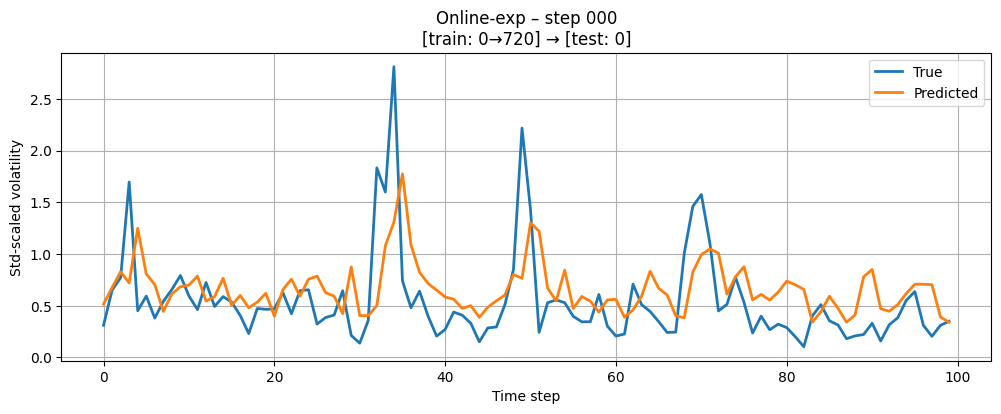

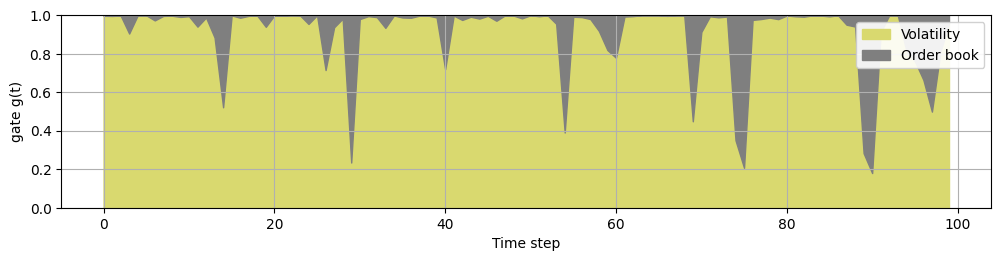

Model saved to saved_models/online_expanding/normal/model_step_1.pt
Original scale residuals saved to saved_residuals/online_expanding/normal/original_residuals_step_1.npy
Predictions saved to saved_predictions/online_expanding/normal/predictions_step_1.npy


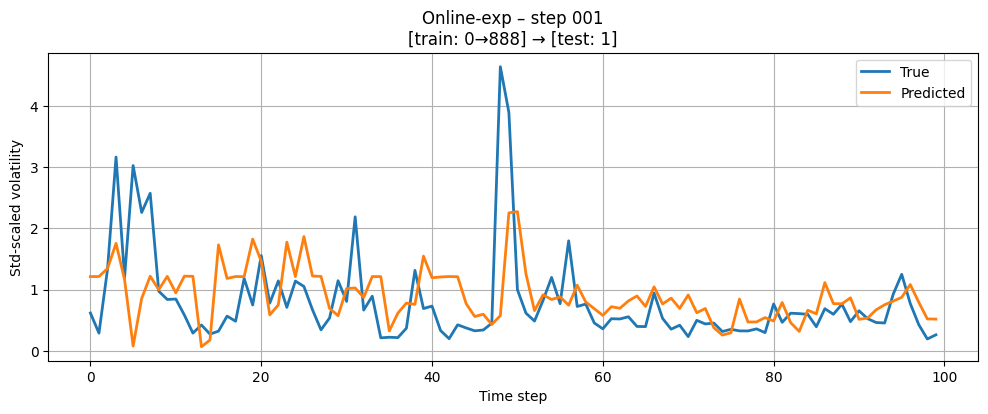

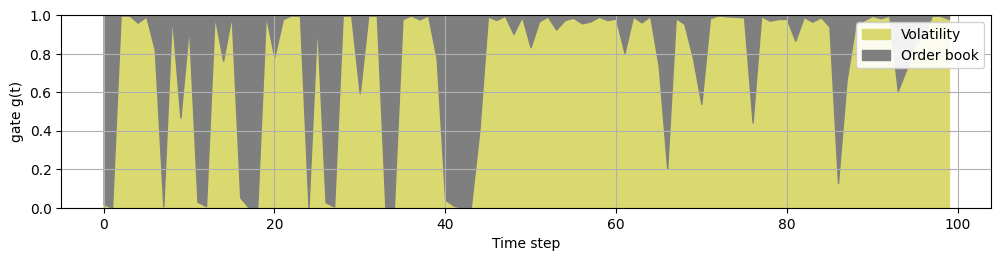

Model saved to saved_models/online_expanding/normal/model_step_2.pt
Original scale residuals saved to saved_residuals/online_expanding/normal/original_residuals_step_2.npy
Predictions saved to saved_predictions/online_expanding/normal/predictions_step_2.npy


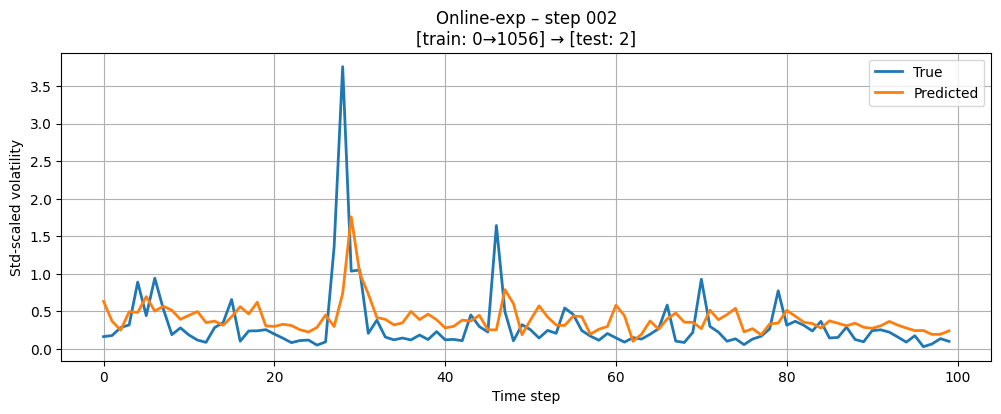

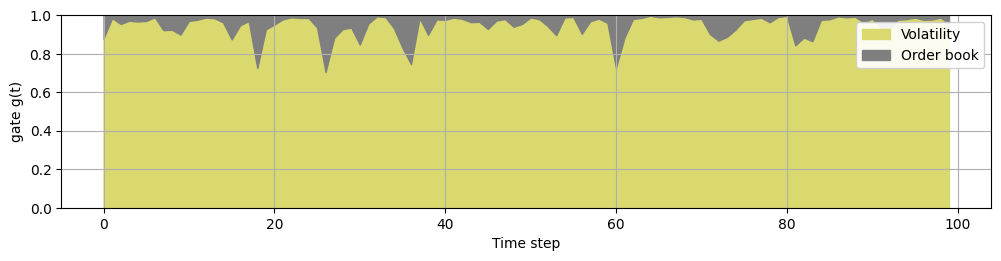

Model saved to saved_models/online_expanding/normal/model_step_3.pt
Original scale residuals saved to saved_residuals/online_expanding/normal/original_residuals_step_3.npy
Predictions saved to saved_predictions/online_expanding/normal/predictions_step_3.npy


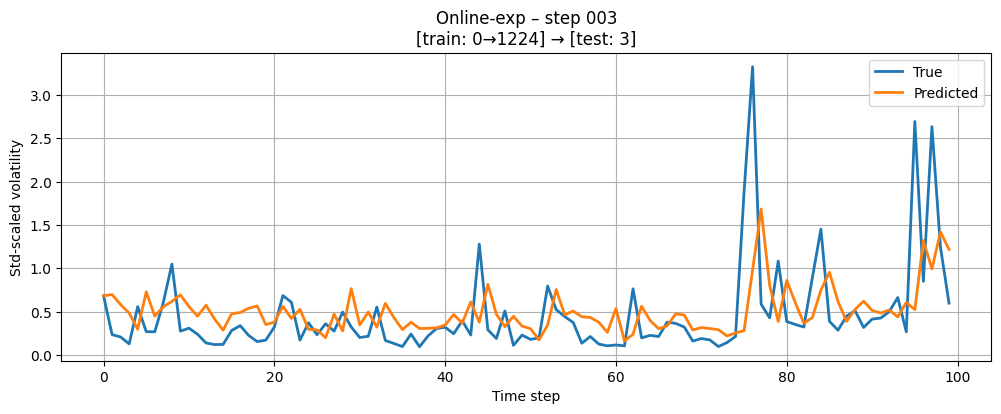

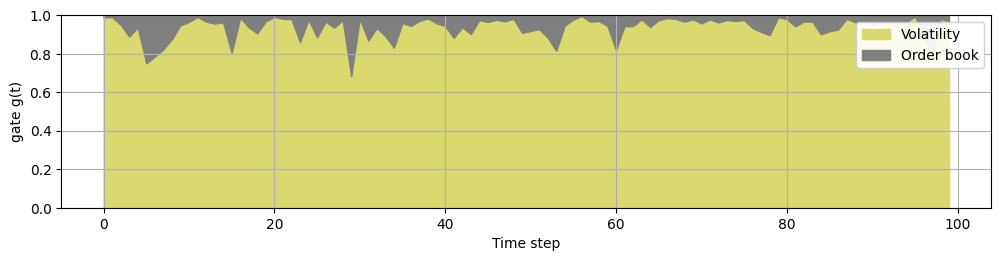

Model saved to saved_models/online_expanding/normal/model_step_4.pt
Original scale residuals saved to saved_residuals/online_expanding/normal/original_residuals_step_4.npy
Predictions saved to saved_predictions/online_expanding/normal/predictions_step_4.npy


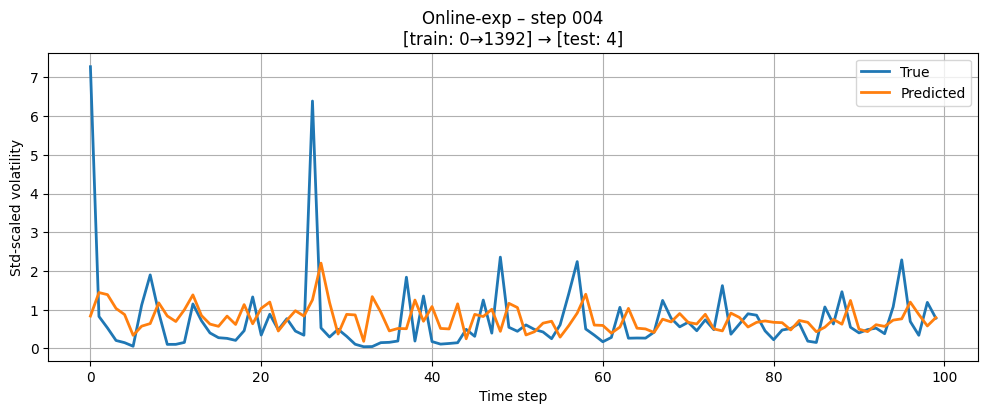

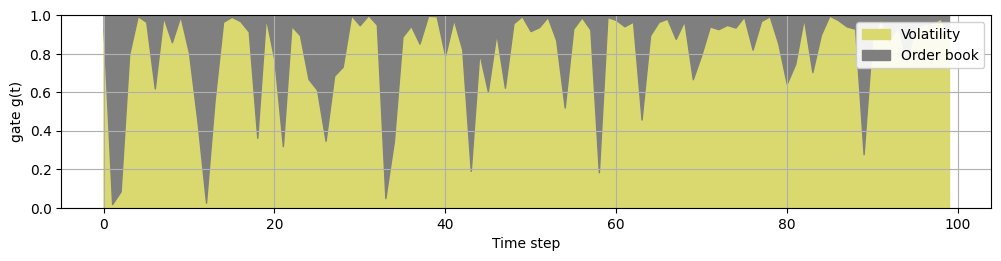

Model saved to saved_models/online_expanding/normal/model_step_5.pt
Original scale residuals saved to saved_residuals/online_expanding/normal/original_residuals_step_5.npy
Predictions saved to saved_predictions/online_expanding/normal/predictions_step_5.npy


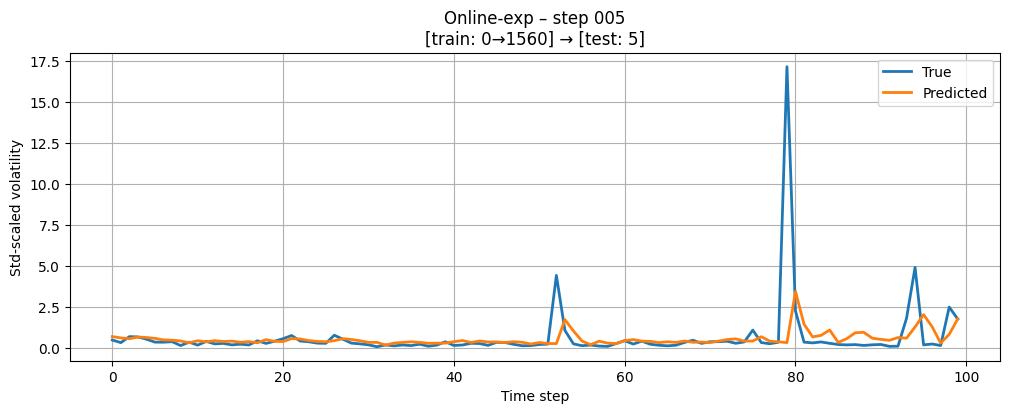

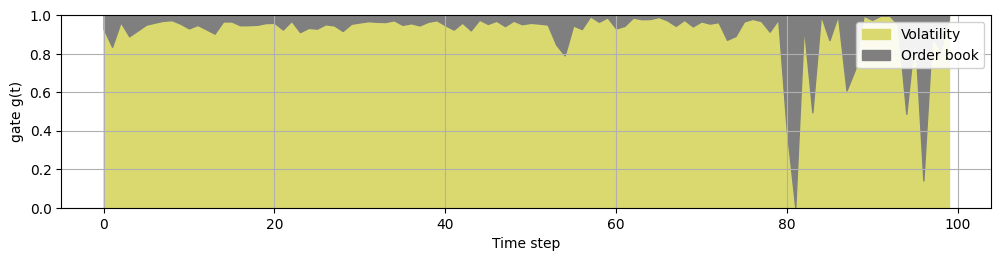

Model saved to saved_models/online_expanding/normal/model_step_6.pt
Original scale residuals saved to saved_residuals/online_expanding/normal/original_residuals_step_6.npy
Predictions saved to saved_predictions/online_expanding/normal/predictions_step_6.npy


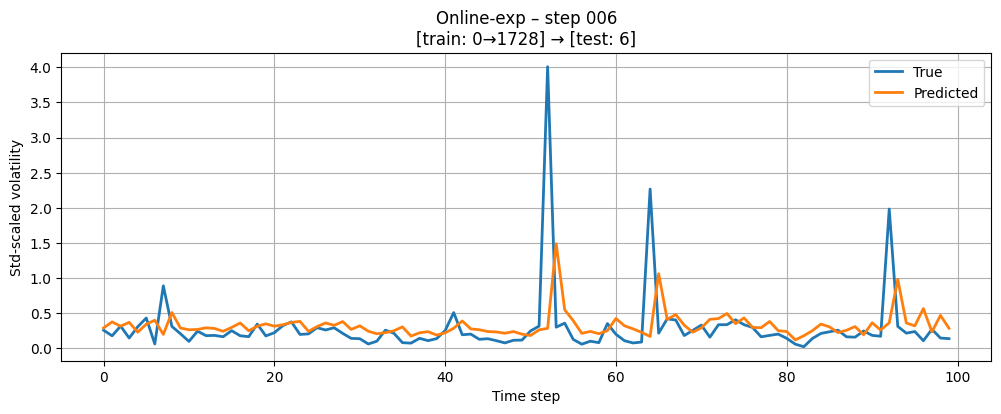

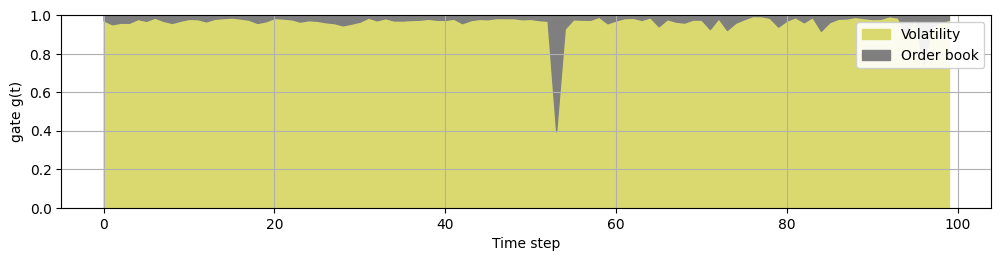

Model saved to saved_models/online_expanding/normal/model_step_7.pt
Original scale residuals saved to saved_residuals/online_expanding/normal/original_residuals_step_7.npy
Predictions saved to saved_predictions/online_expanding/normal/predictions_step_7.npy


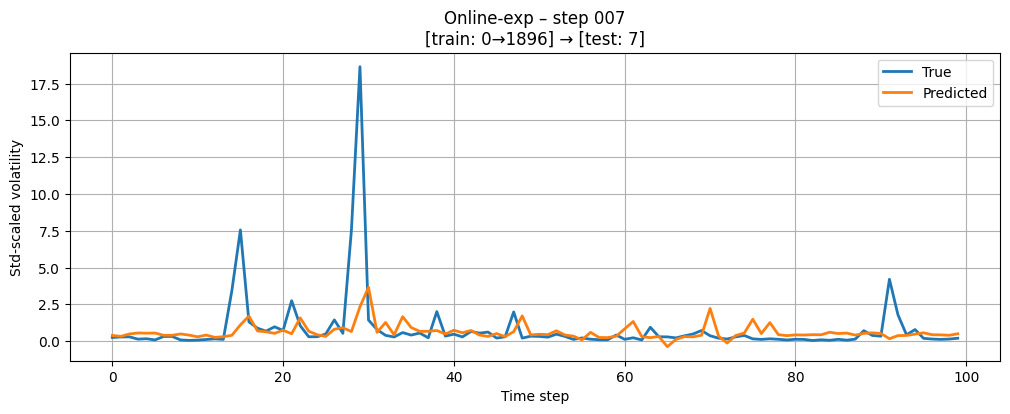

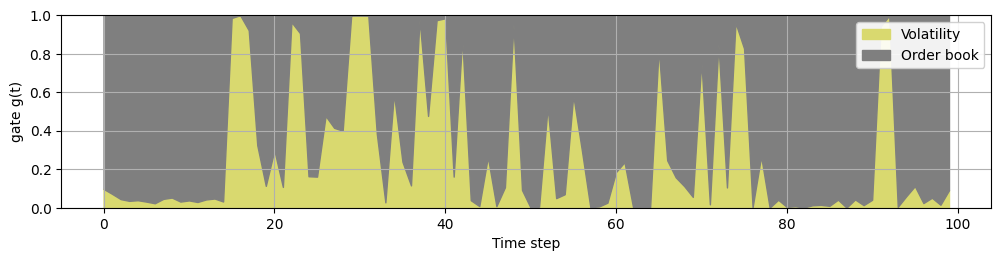

Model saved to saved_models/online_expanding/normal/model_step_8.pt
Original scale residuals saved to saved_residuals/online_expanding/normal/original_residuals_step_8.npy
Predictions saved to saved_predictions/online_expanding/normal/predictions_step_8.npy


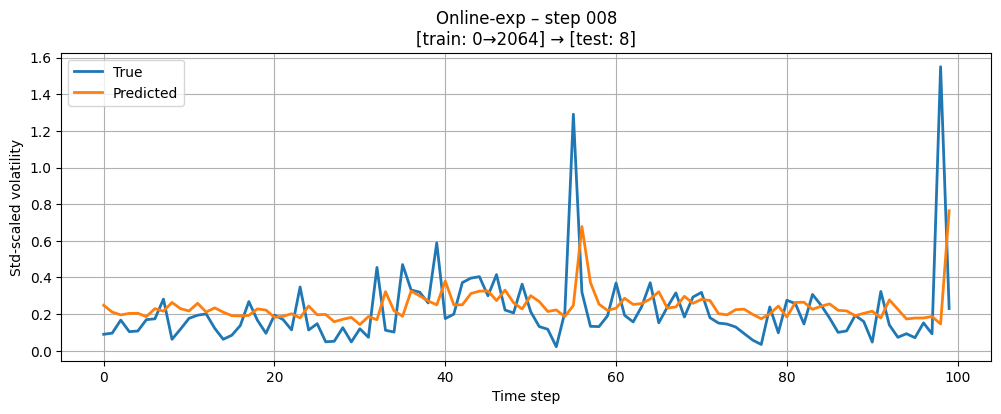

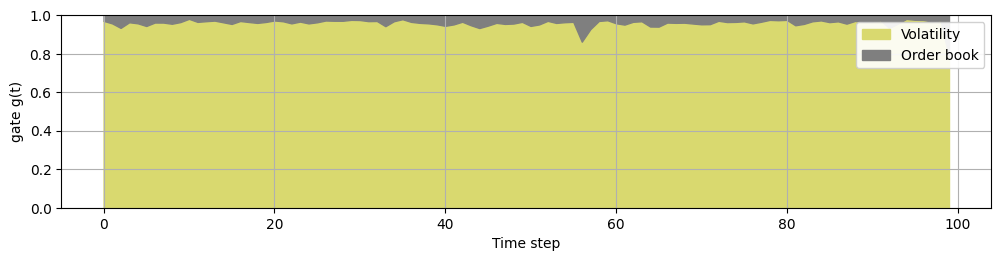

Model saved to saved_models/online_expanding/normal/model_step_9.pt
Original scale residuals saved to saved_residuals/online_expanding/normal/original_residuals_step_9.npy
Predictions saved to saved_predictions/online_expanding/normal/predictions_step_9.npy


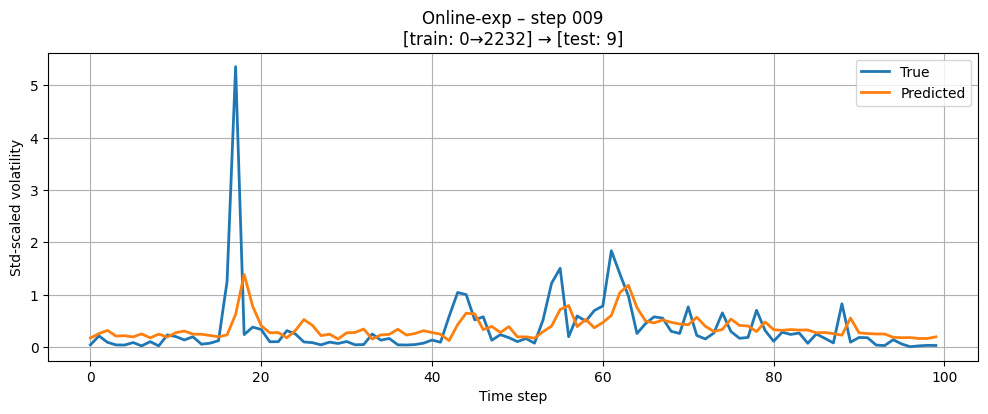

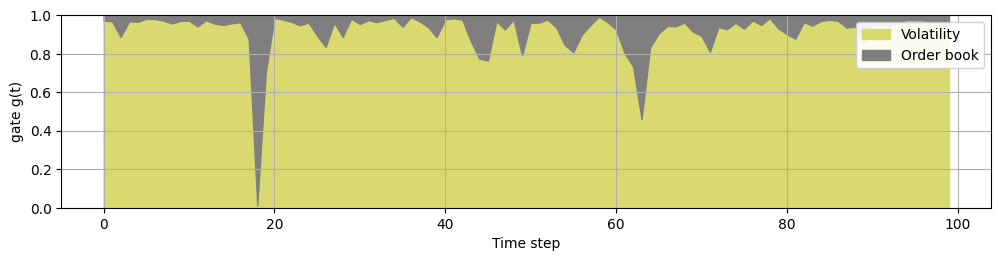

[online-exp] finished 10 steps.

=== Training model: HINGE ===

Model saved to saved_models/online_expanding/hinge/model_step_0.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge/original_residuals_step_0.npy
Predictions saved to saved_predictions/online_expanding/hinge/predictions_step_0.npy


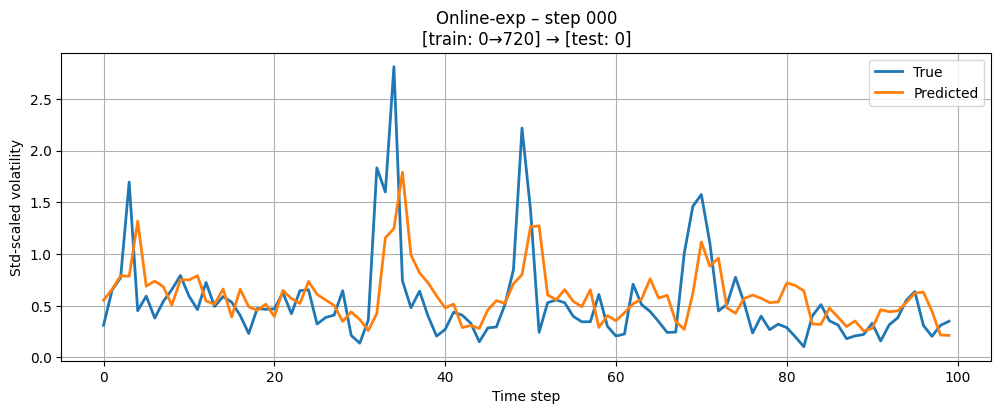

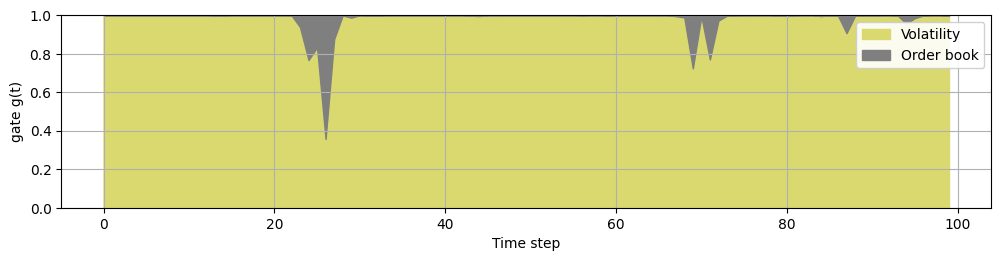

Model saved to saved_models/online_expanding/hinge/model_step_1.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge/original_residuals_step_1.npy
Predictions saved to saved_predictions/online_expanding/hinge/predictions_step_1.npy


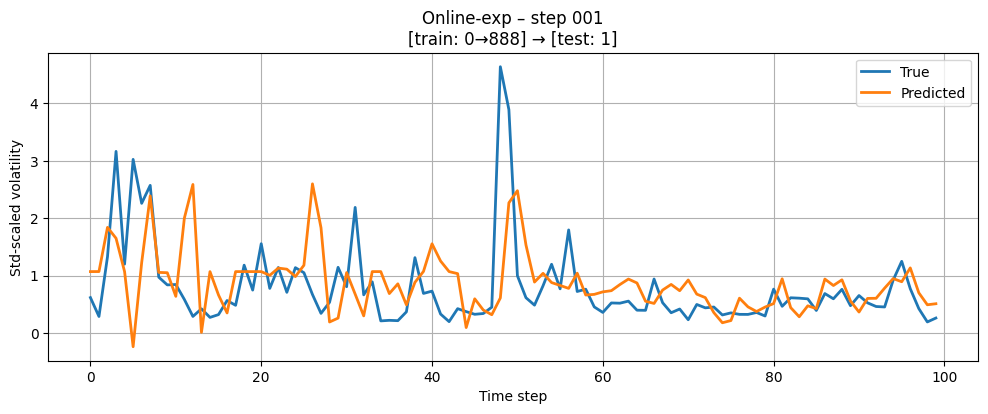

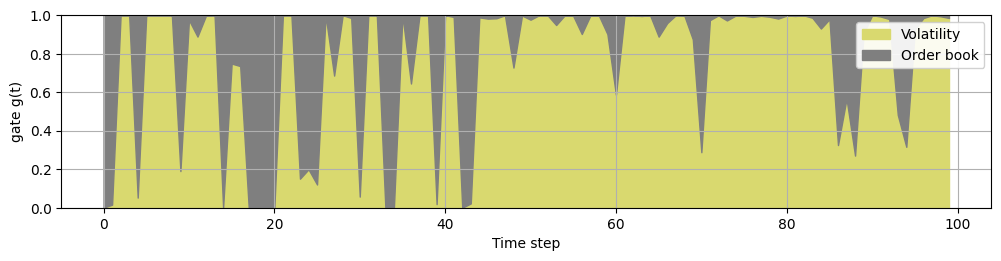

Model saved to saved_models/online_expanding/hinge/model_step_2.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge/original_residuals_step_2.npy
Predictions saved to saved_predictions/online_expanding/hinge/predictions_step_2.npy


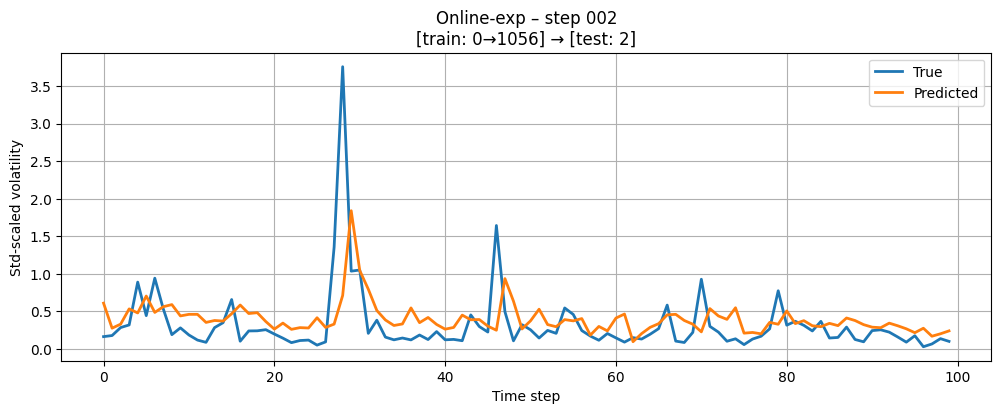

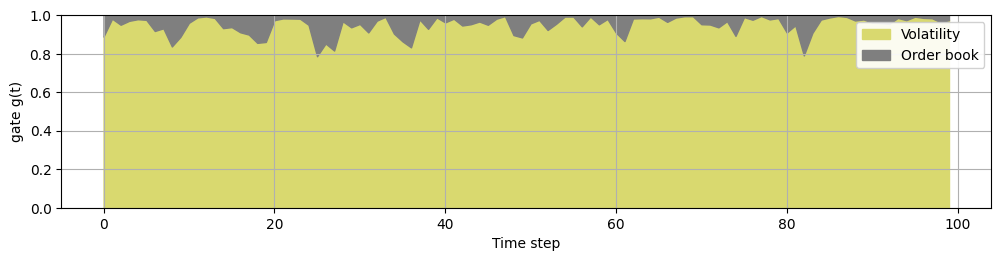

Model saved to saved_models/online_expanding/hinge/model_step_3.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge/original_residuals_step_3.npy
Predictions saved to saved_predictions/online_expanding/hinge/predictions_step_3.npy


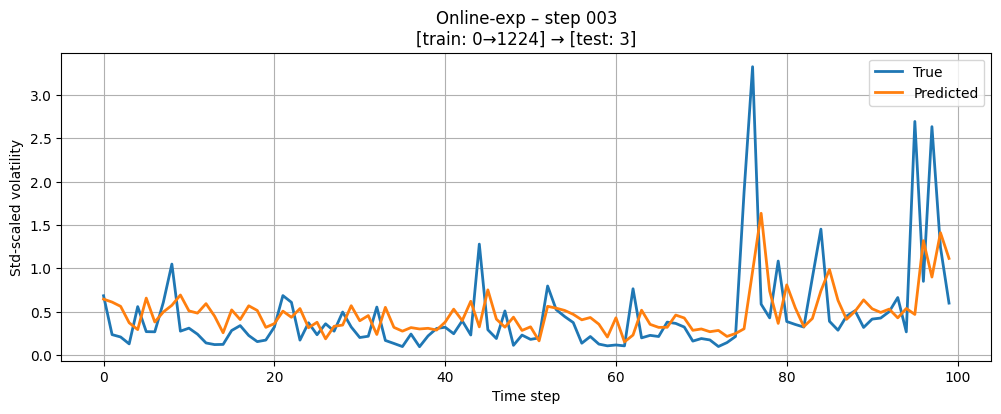

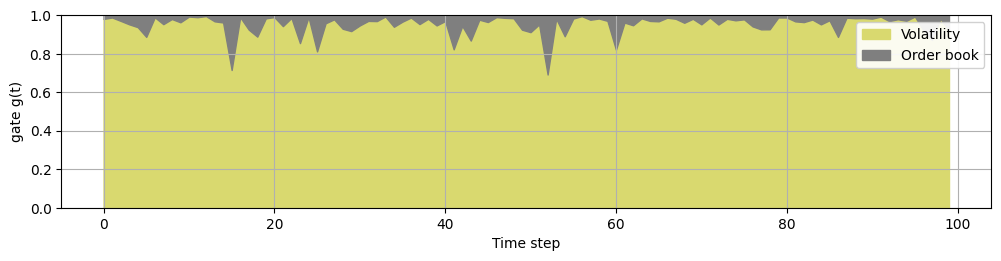

Model saved to saved_models/online_expanding/hinge/model_step_4.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge/original_residuals_step_4.npy
Predictions saved to saved_predictions/online_expanding/hinge/predictions_step_4.npy


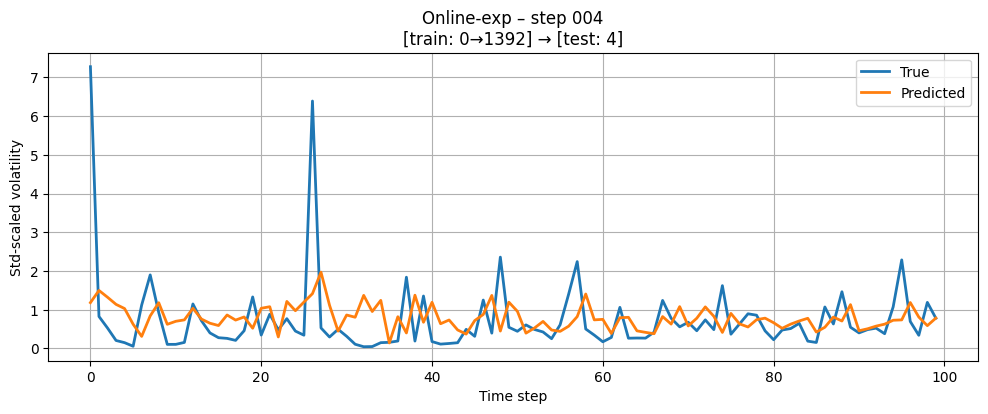

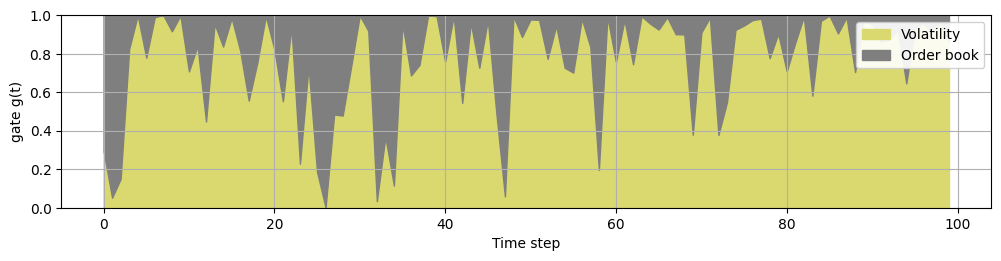

Model saved to saved_models/online_expanding/hinge/model_step_5.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge/original_residuals_step_5.npy
Predictions saved to saved_predictions/online_expanding/hinge/predictions_step_5.npy


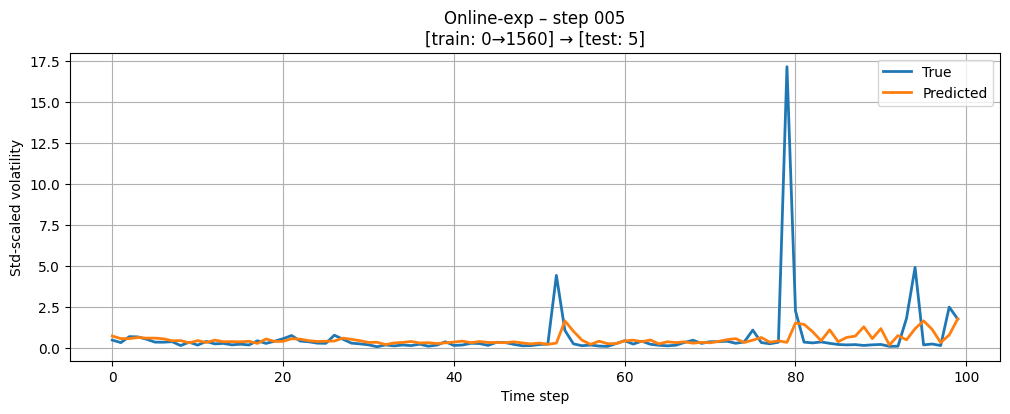

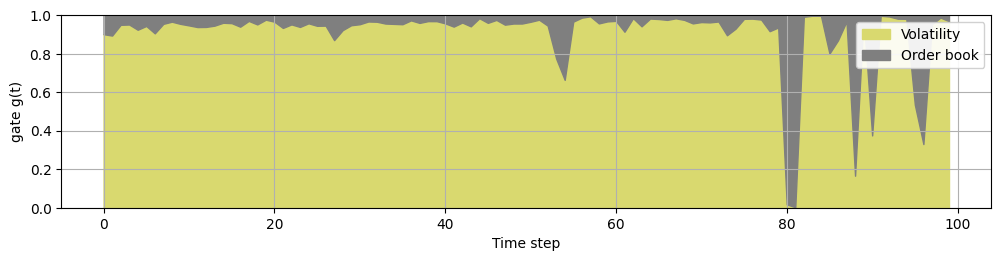

Model saved to saved_models/online_expanding/hinge/model_step_6.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge/original_residuals_step_6.npy
Predictions saved to saved_predictions/online_expanding/hinge/predictions_step_6.npy


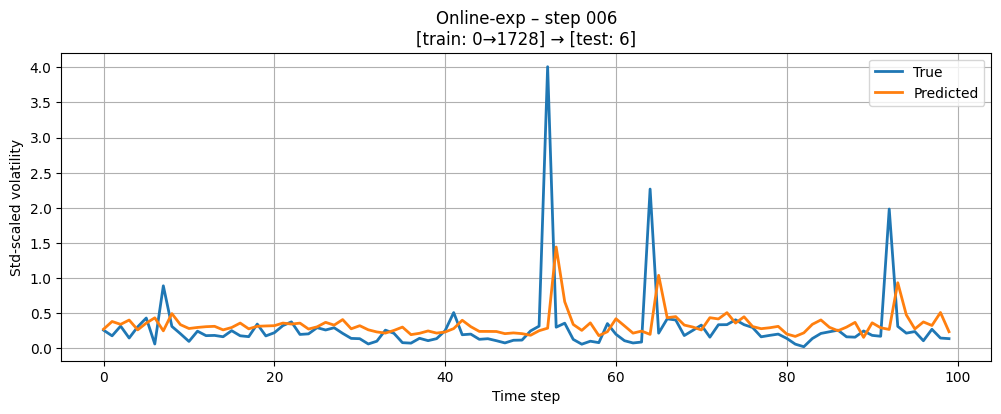

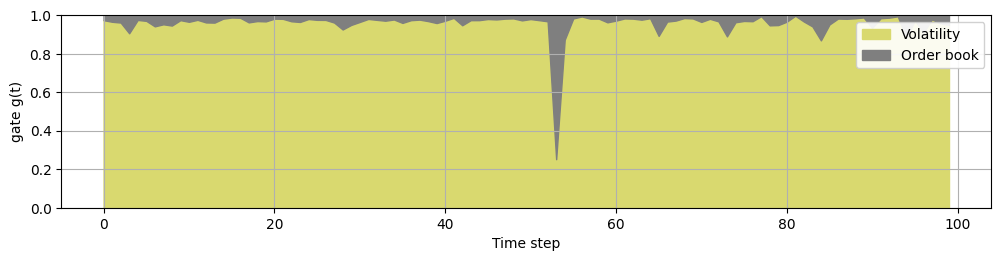

Model saved to saved_models/online_expanding/hinge/model_step_7.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge/original_residuals_step_7.npy
Predictions saved to saved_predictions/online_expanding/hinge/predictions_step_7.npy


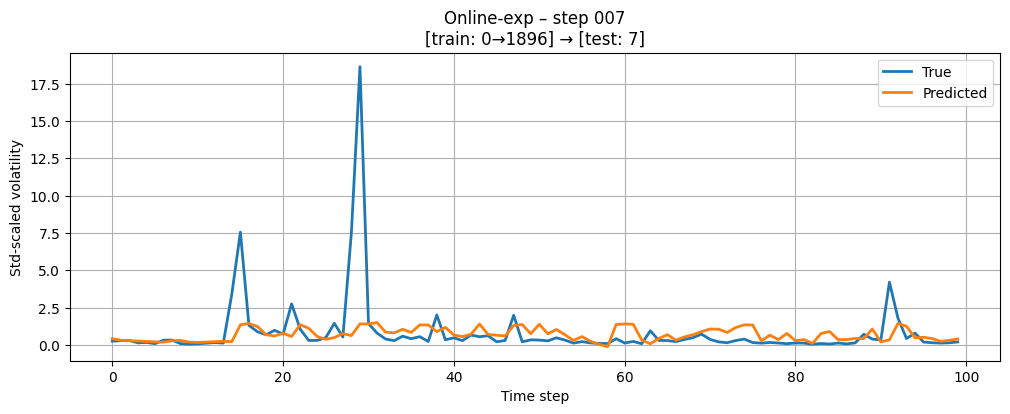

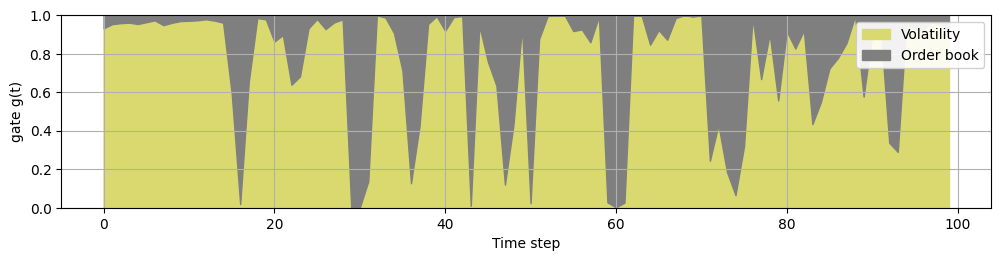

Model saved to saved_models/online_expanding/hinge/model_step_8.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge/original_residuals_step_8.npy
Predictions saved to saved_predictions/online_expanding/hinge/predictions_step_8.npy


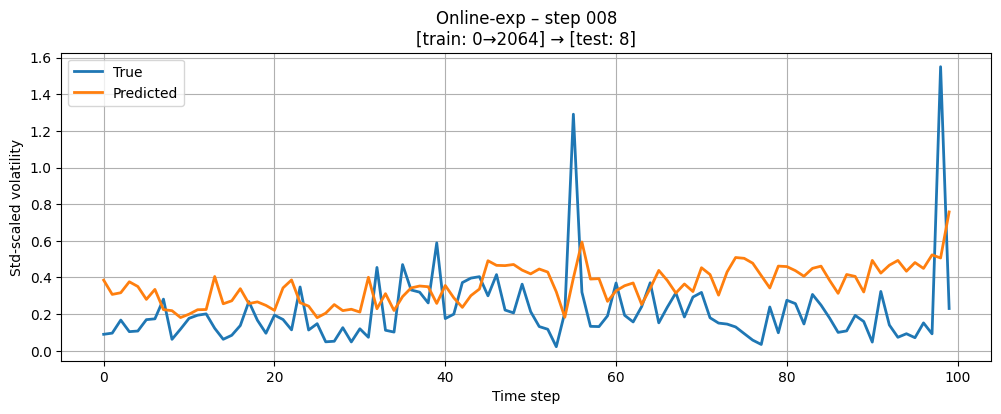

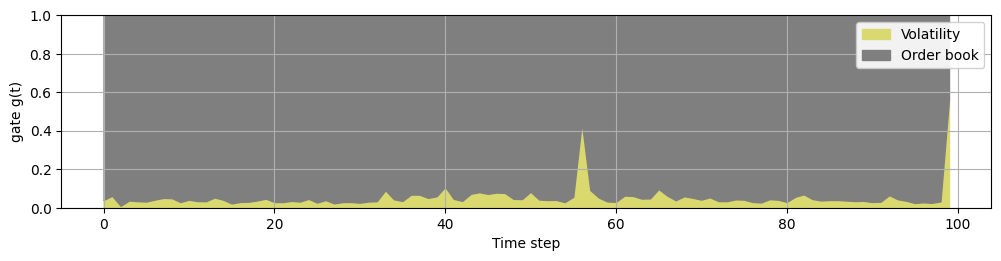

Model saved to saved_models/online_expanding/hinge/model_step_9.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge/original_residuals_step_9.npy
Predictions saved to saved_predictions/online_expanding/hinge/predictions_step_9.npy


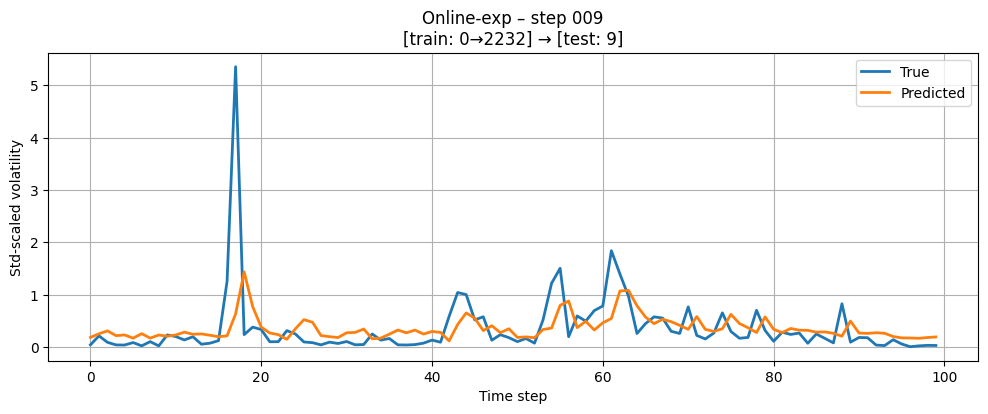

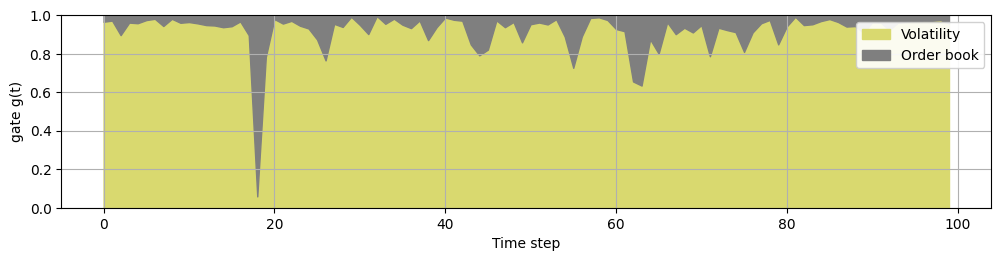

[online-exp] finished 10 steps.

=== Training model: LOGNORMAL ===

Model saved to saved_models/online_expanding/lognormal/model_step_0.pt
Original scale residuals saved to saved_residuals/online_expanding/lognormal/original_residuals_step_0.npy
Predictions saved to saved_predictions/online_expanding/lognormal/predictions_step_0.npy


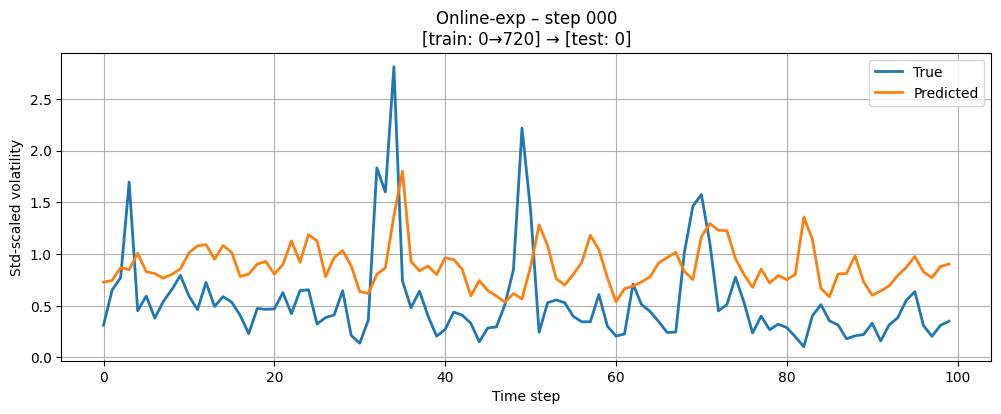

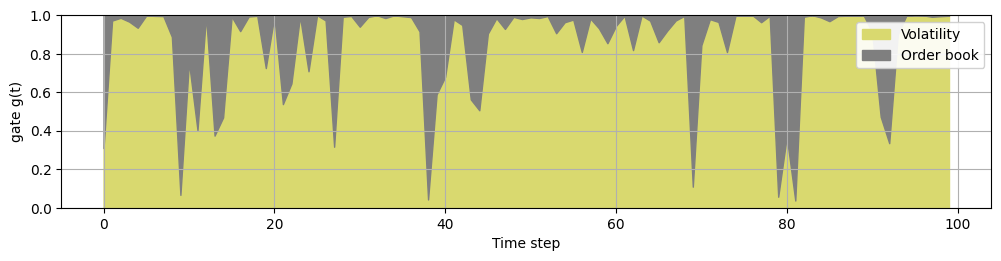

Model saved to saved_models/online_expanding/lognormal/model_step_1.pt
Original scale residuals saved to saved_residuals/online_expanding/lognormal/original_residuals_step_1.npy
Predictions saved to saved_predictions/online_expanding/lognormal/predictions_step_1.npy


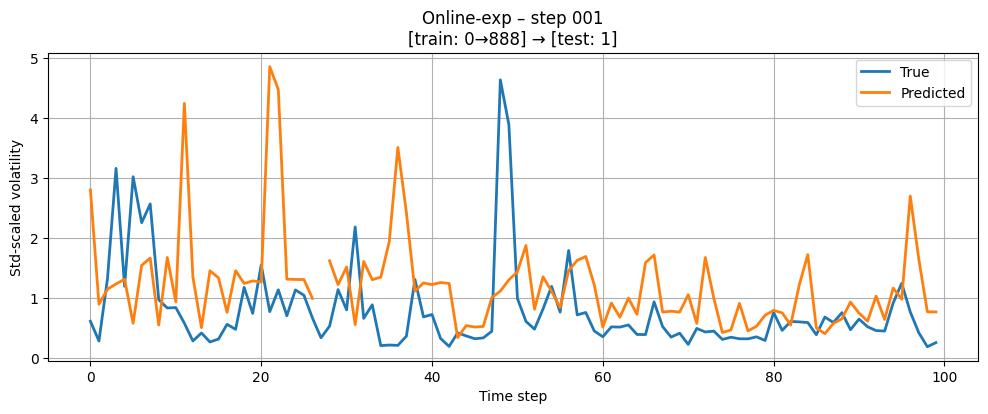

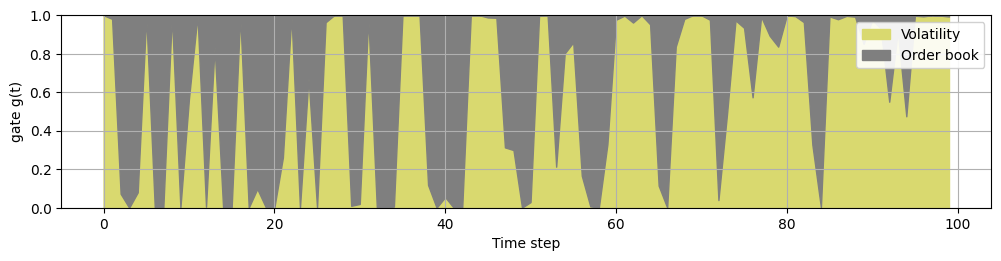

Model saved to saved_models/online_expanding/lognormal/model_step_2.pt
Original scale residuals saved to saved_residuals/online_expanding/lognormal/original_residuals_step_2.npy
Predictions saved to saved_predictions/online_expanding/lognormal/predictions_step_2.npy


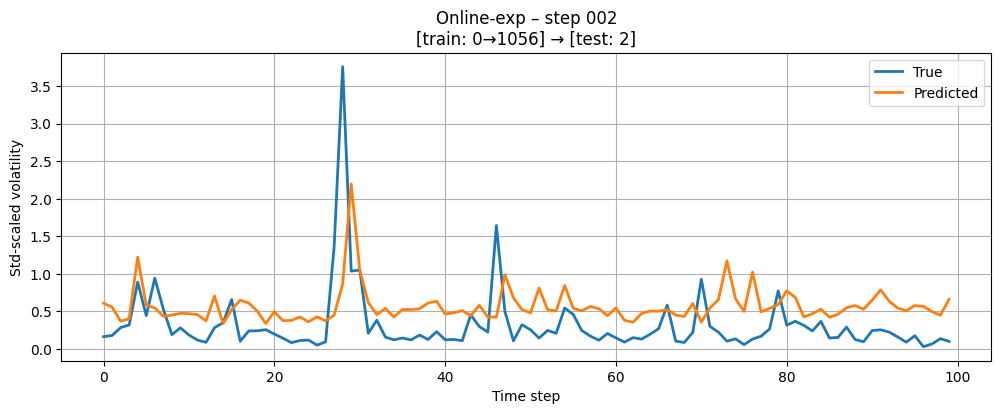

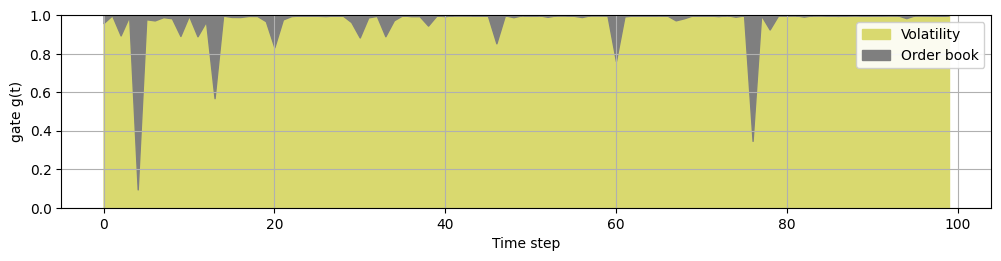

Model saved to saved_models/online_expanding/lognormal/model_step_3.pt
Original scale residuals saved to saved_residuals/online_expanding/lognormal/original_residuals_step_3.npy
Predictions saved to saved_predictions/online_expanding/lognormal/predictions_step_3.npy


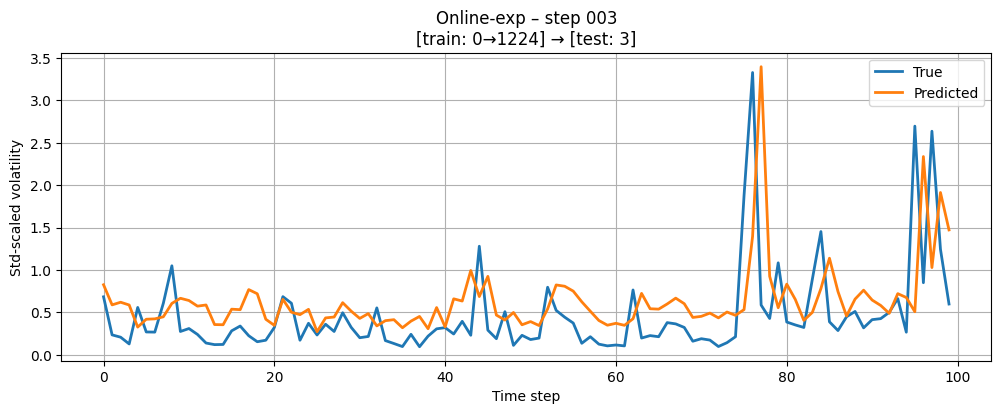

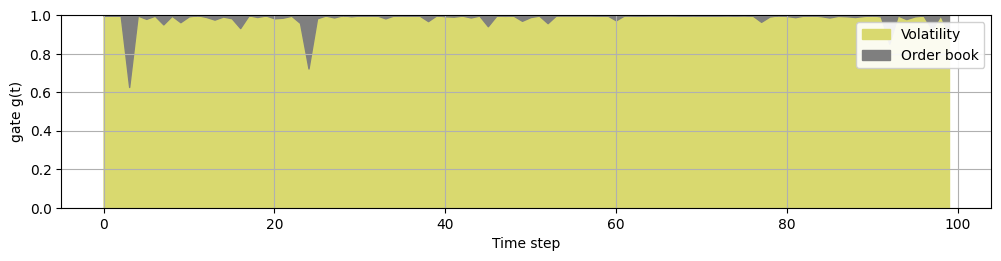

Model saved to saved_models/online_expanding/lognormal/model_step_4.pt
Original scale residuals saved to saved_residuals/online_expanding/lognormal/original_residuals_step_4.npy
Predictions saved to saved_predictions/online_expanding/lognormal/predictions_step_4.npy


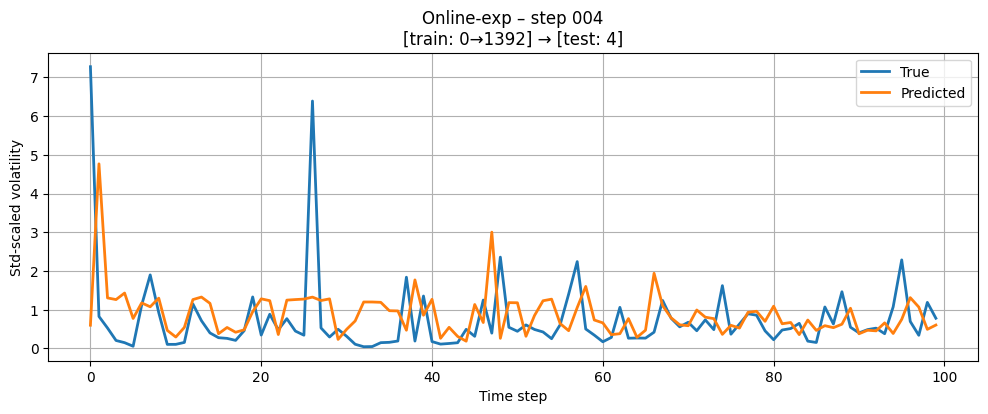

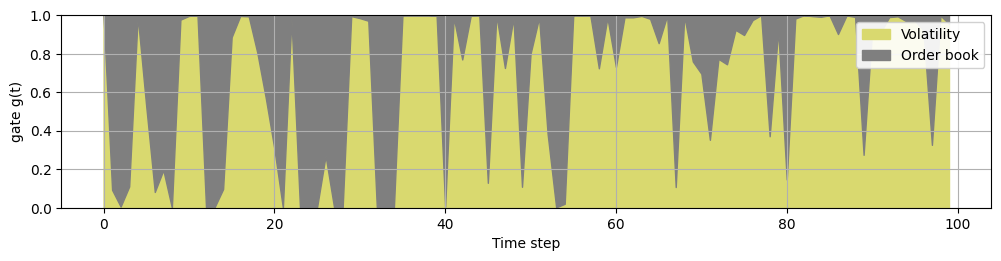

Model saved to saved_models/online_expanding/lognormal/model_step_5.pt
Original scale residuals saved to saved_residuals/online_expanding/lognormal/original_residuals_step_5.npy
Predictions saved to saved_predictions/online_expanding/lognormal/predictions_step_5.npy


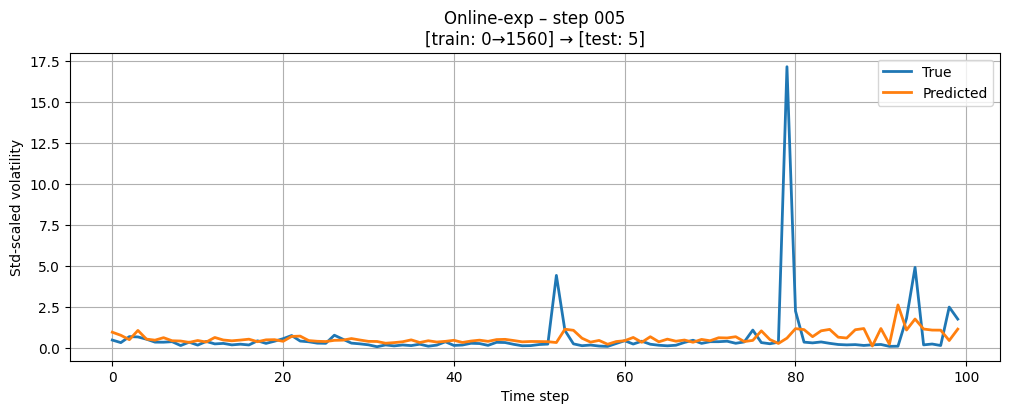

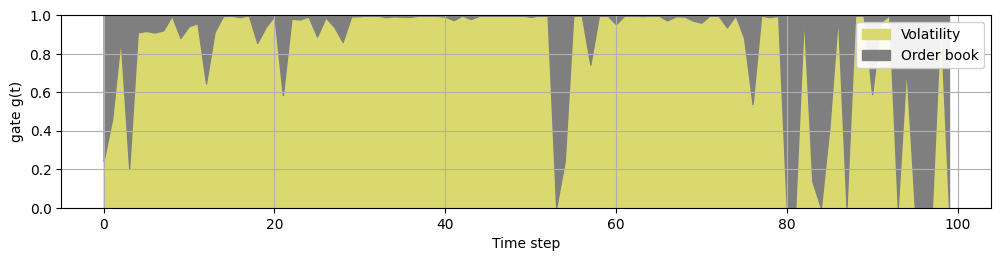

Model saved to saved_models/online_expanding/lognormal/model_step_6.pt
Original scale residuals saved to saved_residuals/online_expanding/lognormal/original_residuals_step_6.npy
Predictions saved to saved_predictions/online_expanding/lognormal/predictions_step_6.npy


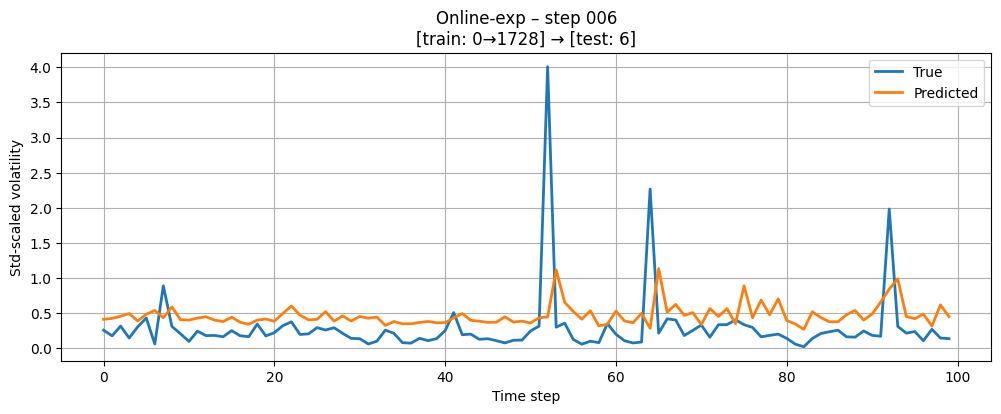

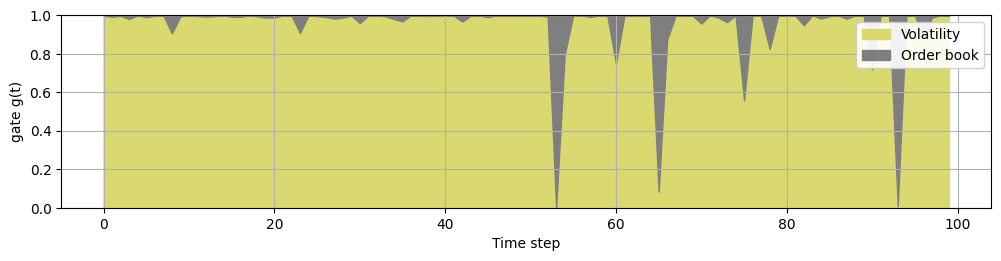

Model saved to saved_models/online_expanding/lognormal/model_step_7.pt
Original scale residuals saved to saved_residuals/online_expanding/lognormal/original_residuals_step_7.npy
Predictions saved to saved_predictions/online_expanding/lognormal/predictions_step_7.npy


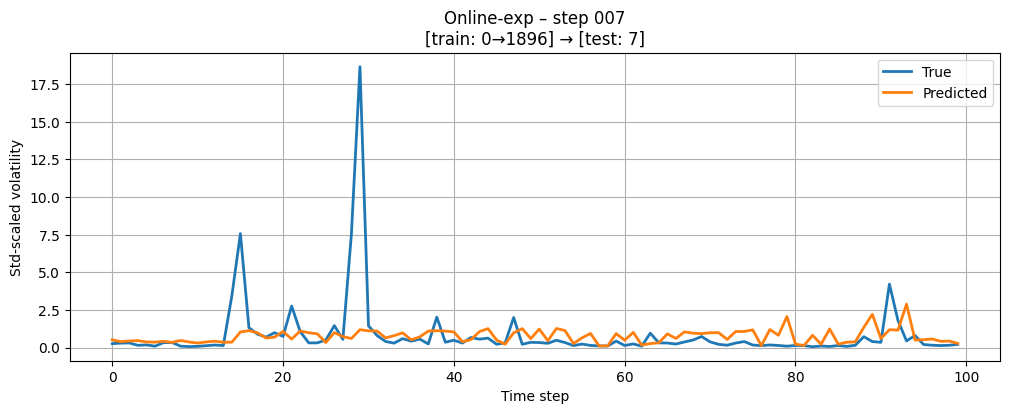

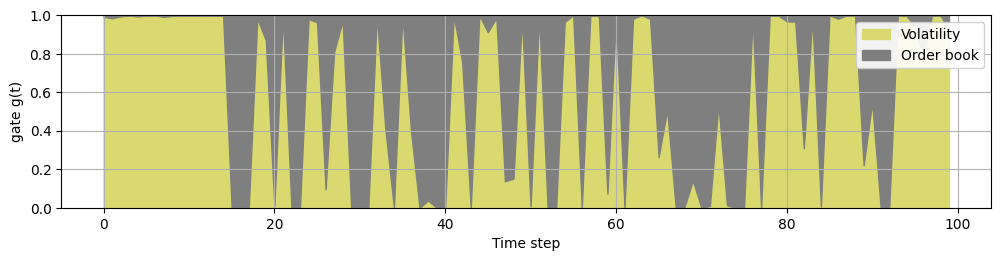

Model saved to saved_models/online_expanding/lognormal/model_step_8.pt
Original scale residuals saved to saved_residuals/online_expanding/lognormal/original_residuals_step_8.npy
Predictions saved to saved_predictions/online_expanding/lognormal/predictions_step_8.npy


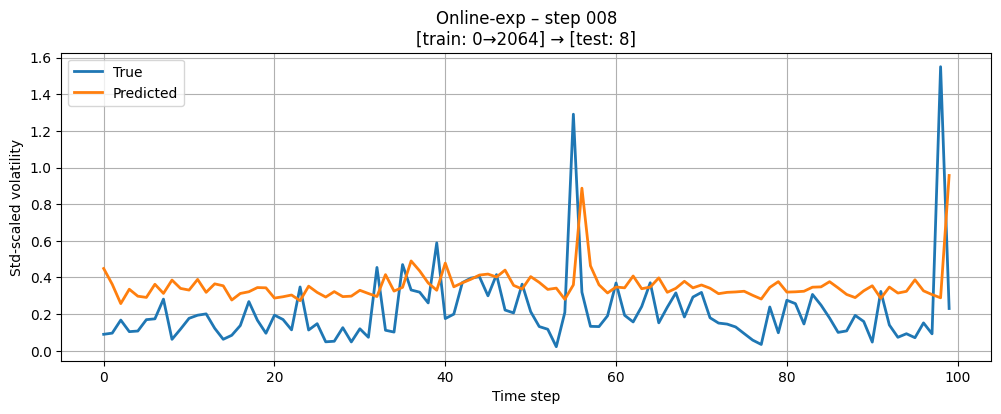

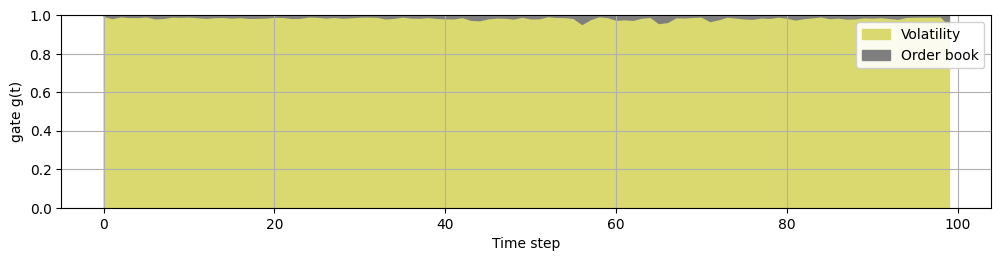

Model saved to saved_models/online_expanding/lognormal/model_step_9.pt
Original scale residuals saved to saved_residuals/online_expanding/lognormal/original_residuals_step_9.npy
Predictions saved to saved_predictions/online_expanding/lognormal/predictions_step_9.npy


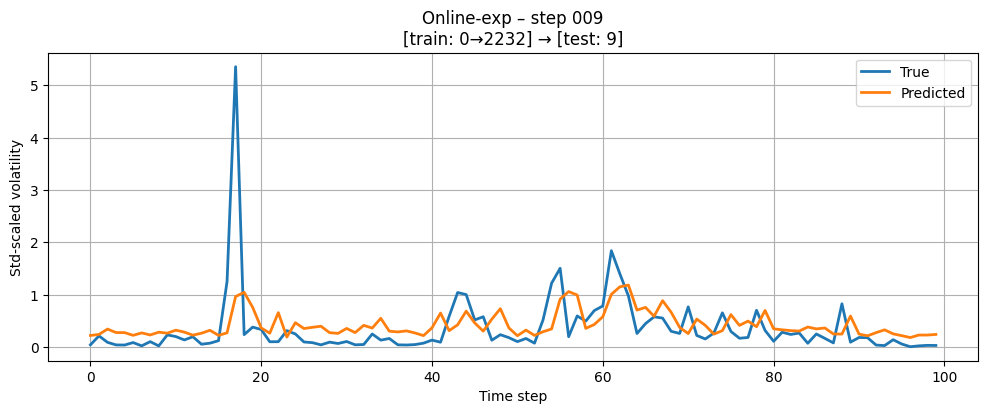

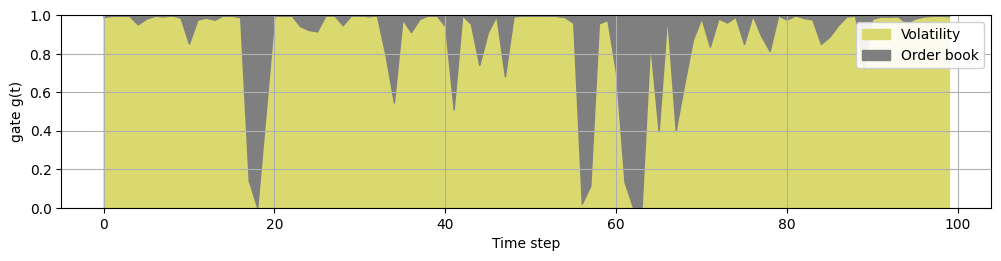

[online-exp] finished 10 steps.

=== Training model: INVERSE_GAUSSIAN ===

Model saved to saved_models/online_expanding/inverse_gaussian/model_step_0.pt
Original scale residuals saved to saved_residuals/online_expanding/inverse_gaussian/original_residuals_step_0.npy
Predictions saved to saved_predictions/online_expanding/inverse_gaussian/predictions_step_0.npy


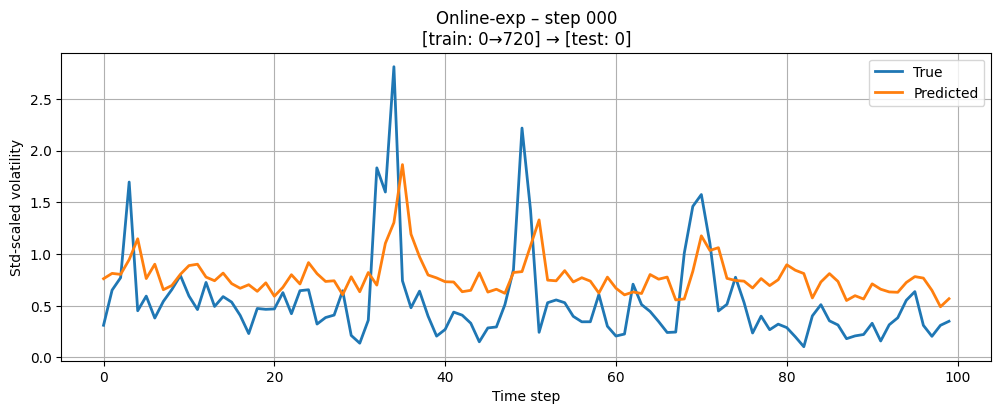

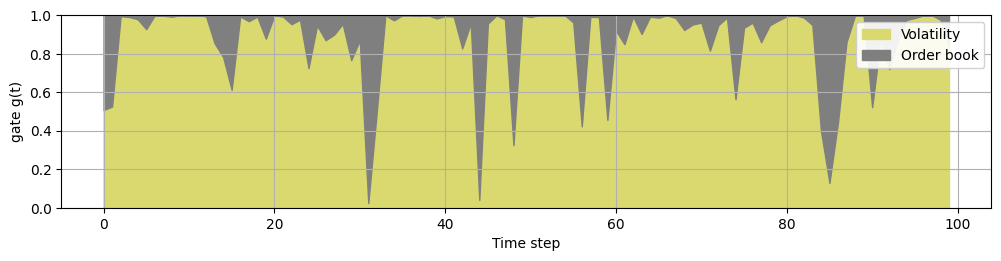

Model saved to saved_models/online_expanding/inverse_gaussian/model_step_1.pt
Original scale residuals saved to saved_residuals/online_expanding/inverse_gaussian/original_residuals_step_1.npy
Predictions saved to saved_predictions/online_expanding/inverse_gaussian/predictions_step_1.npy


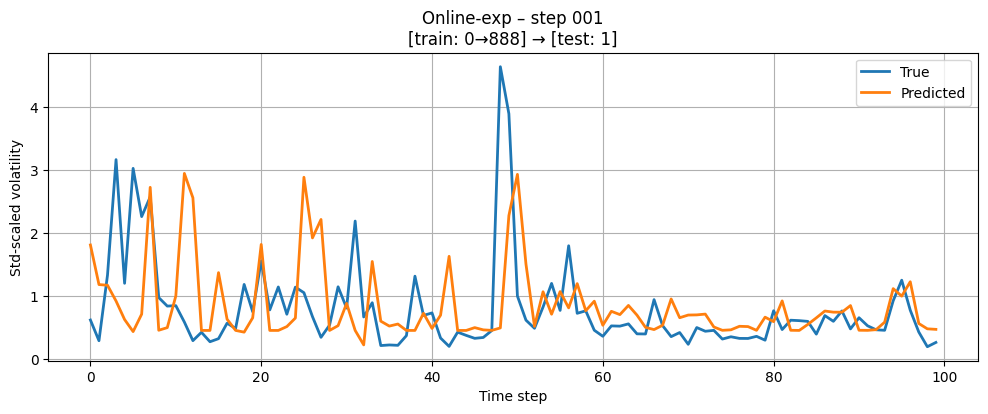

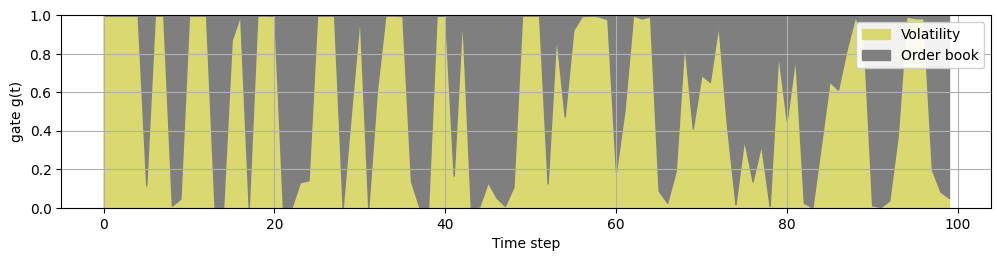

Model saved to saved_models/online_expanding/inverse_gaussian/model_step_2.pt
Original scale residuals saved to saved_residuals/online_expanding/inverse_gaussian/original_residuals_step_2.npy
Predictions saved to saved_predictions/online_expanding/inverse_gaussian/predictions_step_2.npy


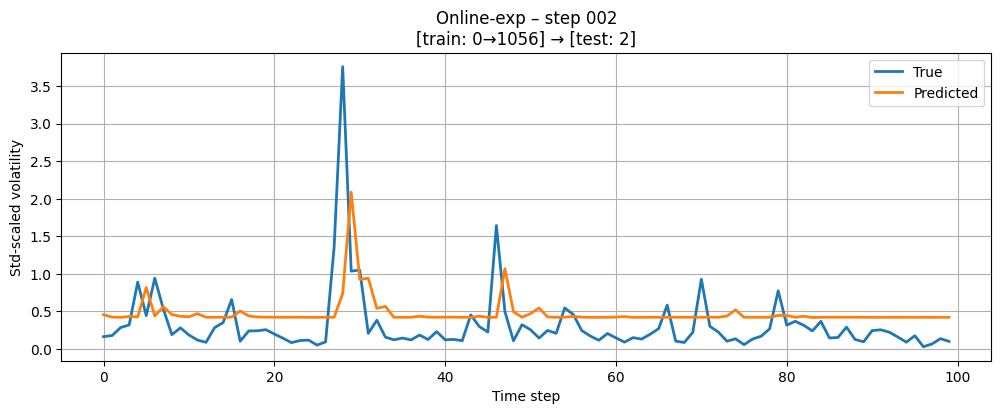

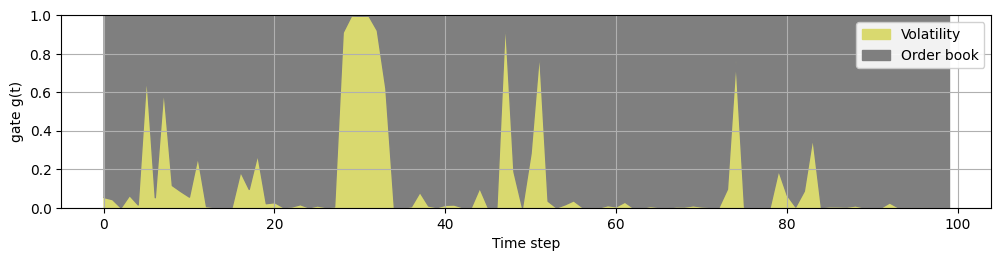

Model saved to saved_models/online_expanding/inverse_gaussian/model_step_3.pt
Original scale residuals saved to saved_residuals/online_expanding/inverse_gaussian/original_residuals_step_3.npy
Predictions saved to saved_predictions/online_expanding/inverse_gaussian/predictions_step_3.npy


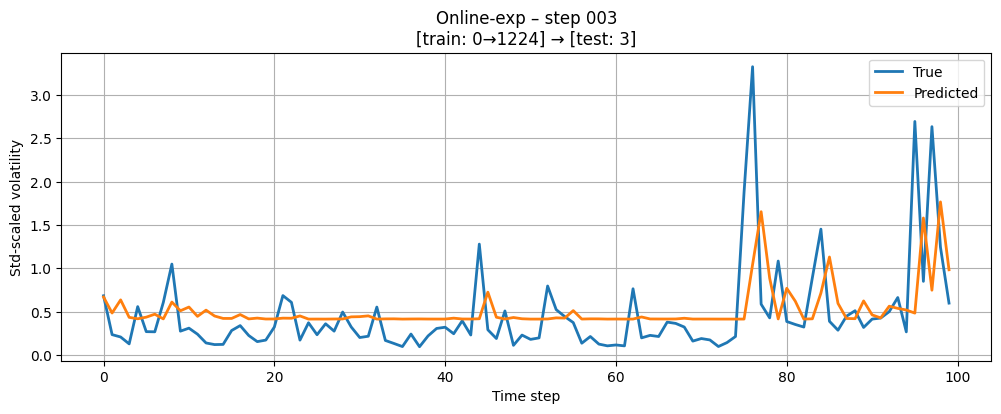

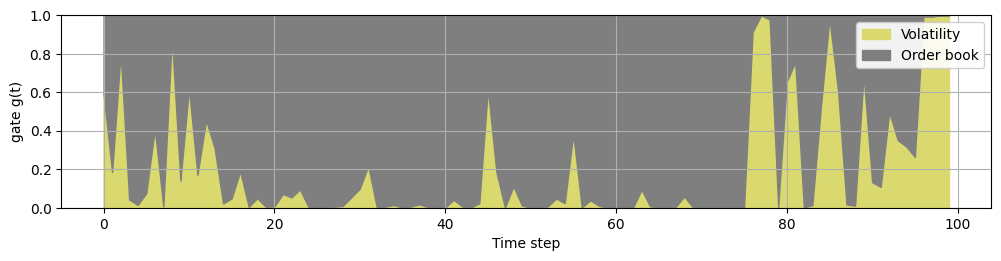

Model saved to saved_models/online_expanding/inverse_gaussian/model_step_4.pt
Original scale residuals saved to saved_residuals/online_expanding/inverse_gaussian/original_residuals_step_4.npy
Predictions saved to saved_predictions/online_expanding/inverse_gaussian/predictions_step_4.npy


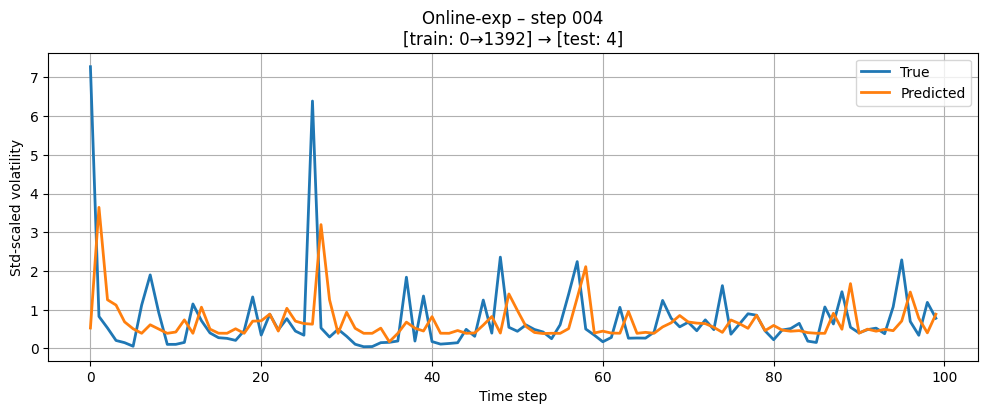

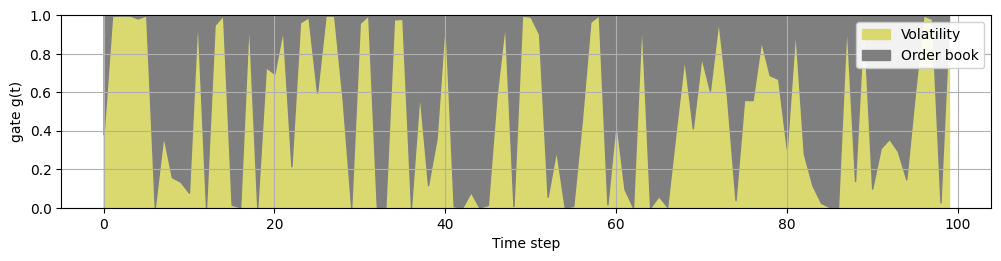

Model saved to saved_models/online_expanding/inverse_gaussian/model_step_5.pt
Original scale residuals saved to saved_residuals/online_expanding/inverse_gaussian/original_residuals_step_5.npy
Predictions saved to saved_predictions/online_expanding/inverse_gaussian/predictions_step_5.npy


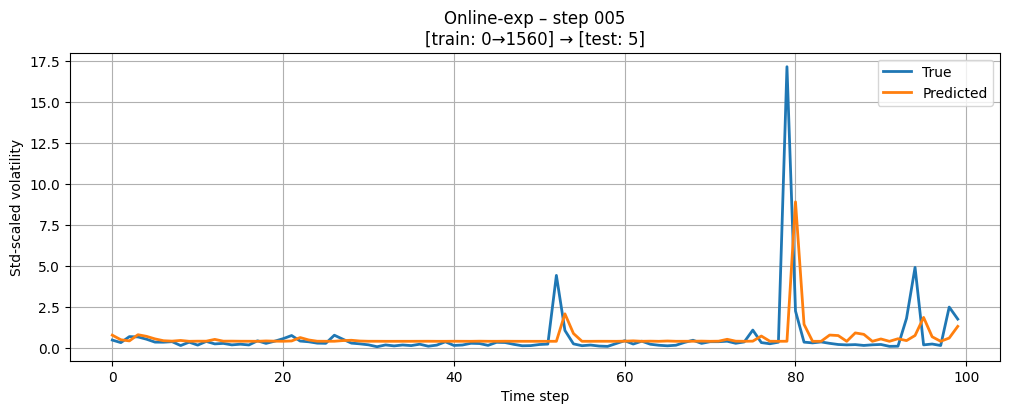

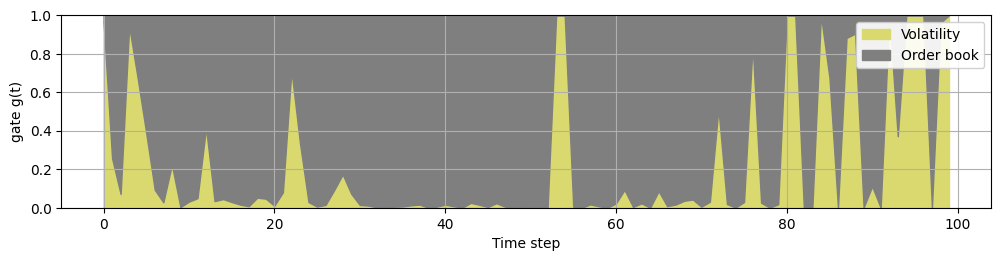

Model saved to saved_models/online_expanding/inverse_gaussian/model_step_6.pt
Original scale residuals saved to saved_residuals/online_expanding/inverse_gaussian/original_residuals_step_6.npy
Predictions saved to saved_predictions/online_expanding/inverse_gaussian/predictions_step_6.npy


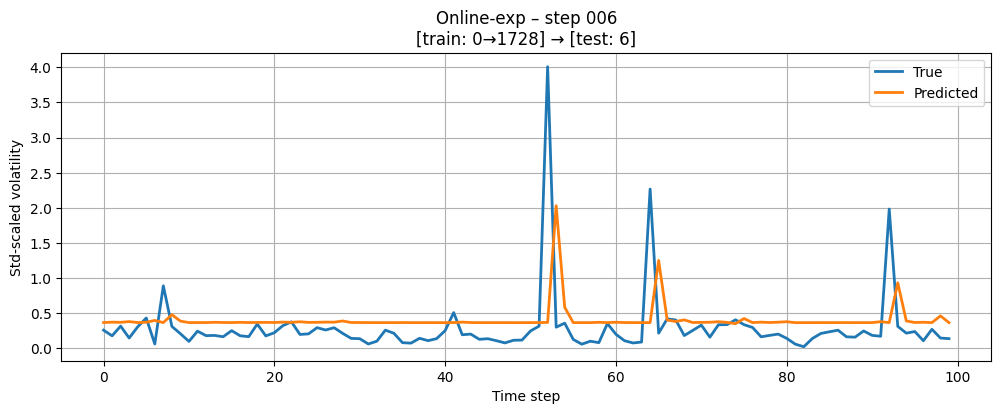

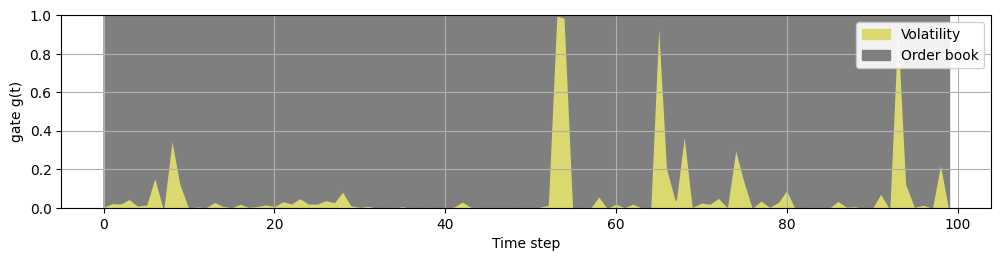

Model saved to saved_models/online_expanding/inverse_gaussian/model_step_7.pt
Original scale residuals saved to saved_residuals/online_expanding/inverse_gaussian/original_residuals_step_7.npy
Predictions saved to saved_predictions/online_expanding/inverse_gaussian/predictions_step_7.npy


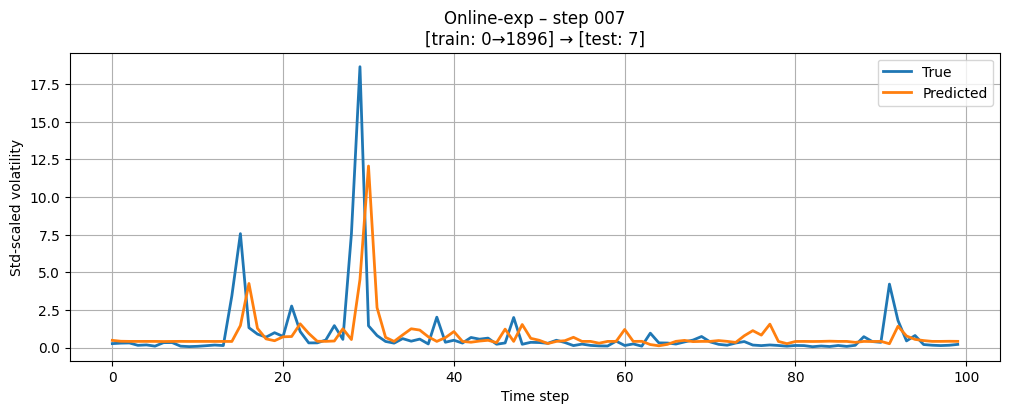

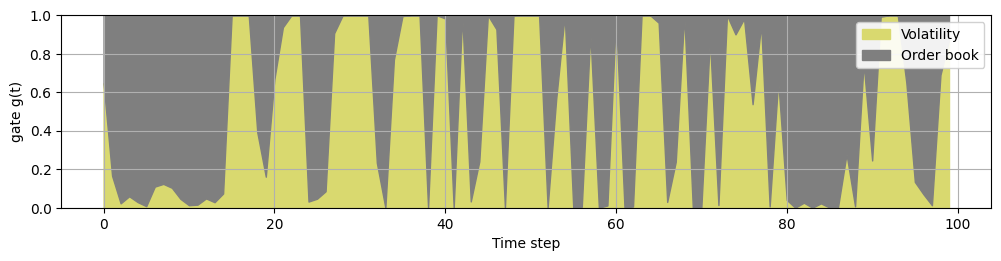

Model saved to saved_models/online_expanding/inverse_gaussian/model_step_8.pt
Original scale residuals saved to saved_residuals/online_expanding/inverse_gaussian/original_residuals_step_8.npy
Predictions saved to saved_predictions/online_expanding/inverse_gaussian/predictions_step_8.npy


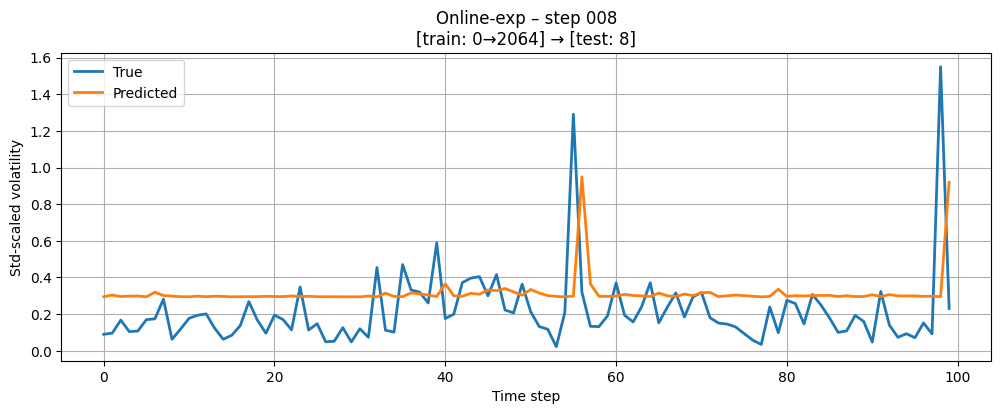

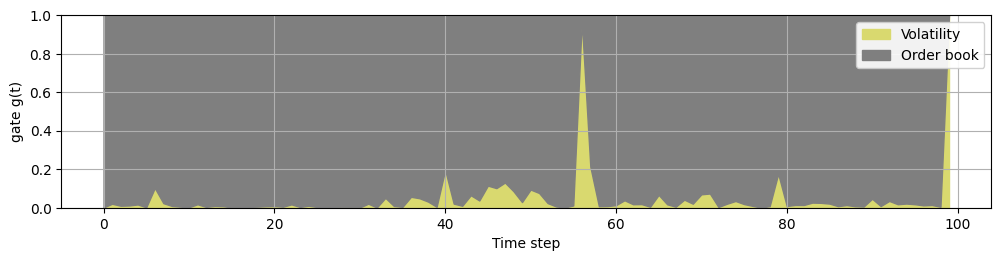

Model saved to saved_models/online_expanding/inverse_gaussian/model_step_9.pt
Original scale residuals saved to saved_residuals/online_expanding/inverse_gaussian/original_residuals_step_9.npy
Predictions saved to saved_predictions/online_expanding/inverse_gaussian/predictions_step_9.npy


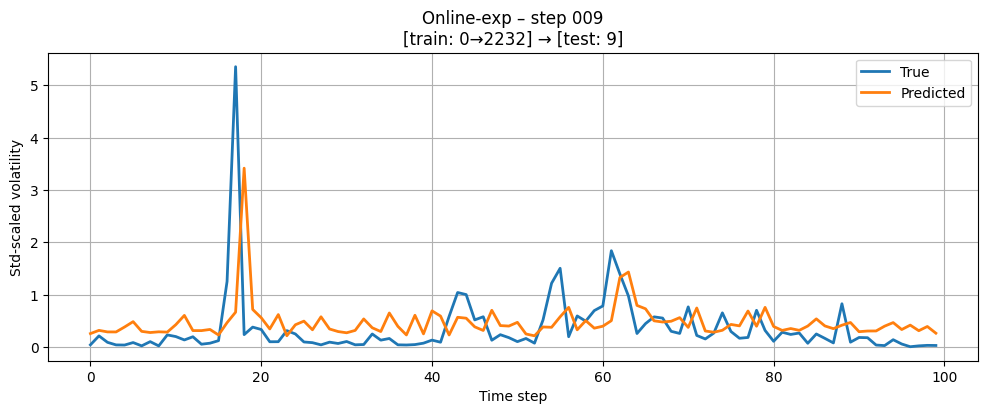

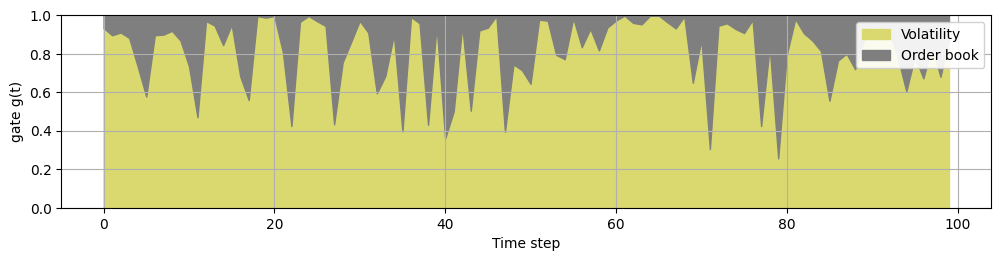

[online-exp] finished 10 steps.

=== Training model: WEIBULL ===

Model saved to saved_models/online_expanding/weibull/model_step_0.pt
Original scale residuals saved to saved_residuals/online_expanding/weibull/original_residuals_step_0.npy
Predictions saved to saved_predictions/online_expanding/weibull/predictions_step_0.npy


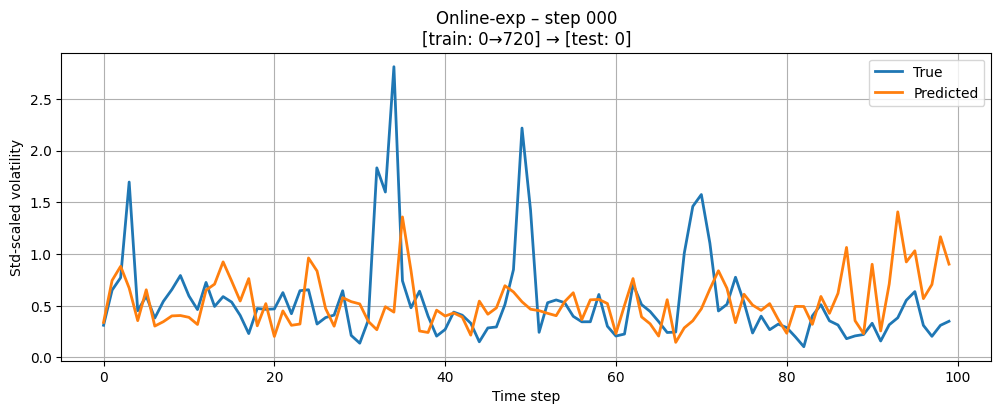

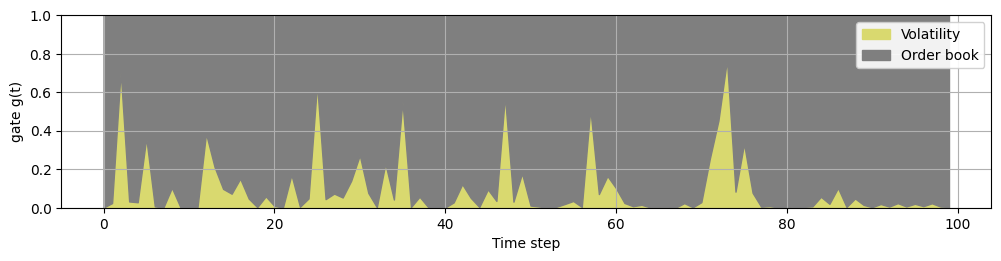

Model saved to saved_models/online_expanding/weibull/model_step_1.pt
Original scale residuals saved to saved_residuals/online_expanding/weibull/original_residuals_step_1.npy
Predictions saved to saved_predictions/online_expanding/weibull/predictions_step_1.npy


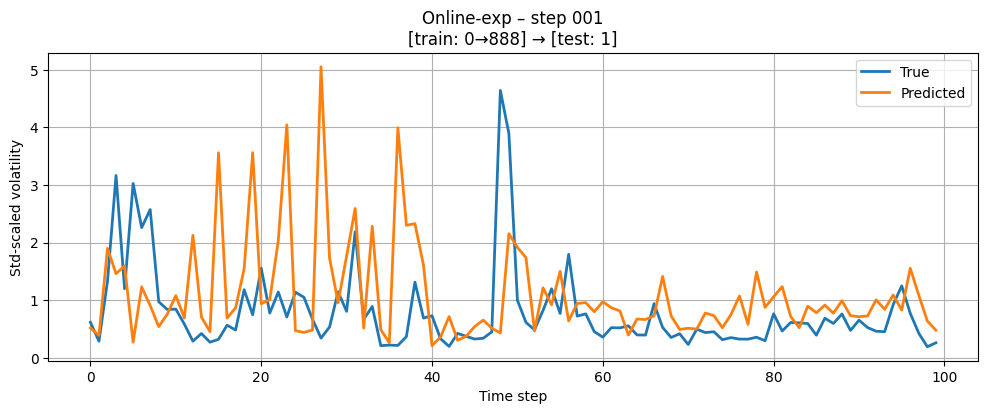

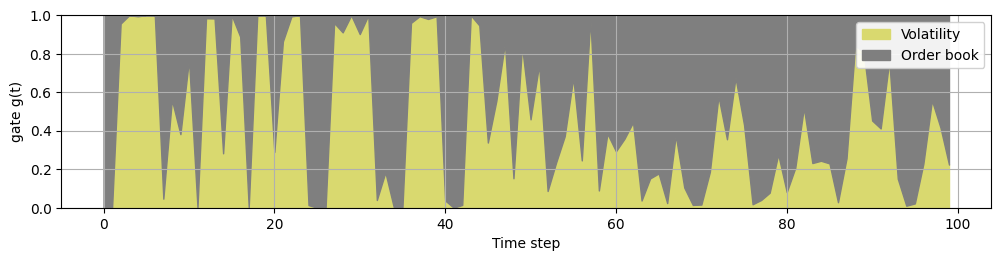

Model saved to saved_models/online_expanding/weibull/model_step_2.pt
Original scale residuals saved to saved_residuals/online_expanding/weibull/original_residuals_step_2.npy
Predictions saved to saved_predictions/online_expanding/weibull/predictions_step_2.npy


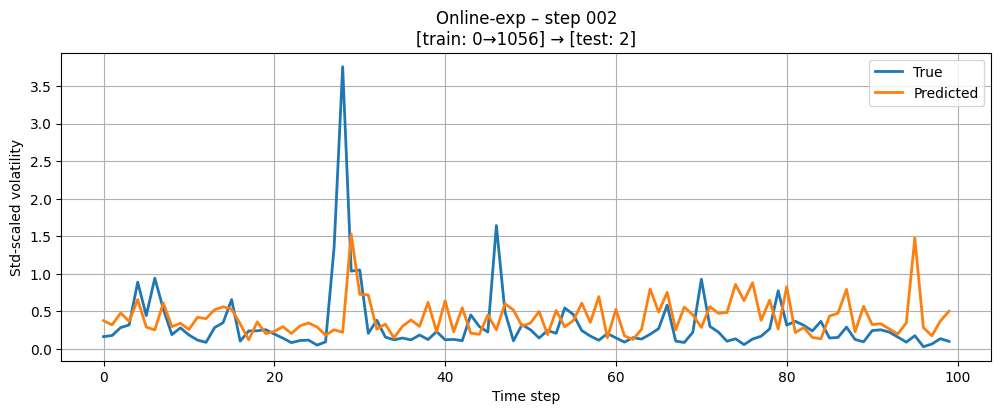

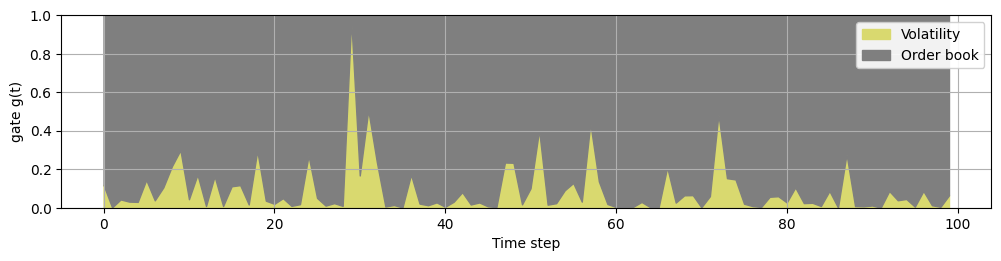

Model saved to saved_models/online_expanding/weibull/model_step_3.pt
Original scale residuals saved to saved_residuals/online_expanding/weibull/original_residuals_step_3.npy
Predictions saved to saved_predictions/online_expanding/weibull/predictions_step_3.npy


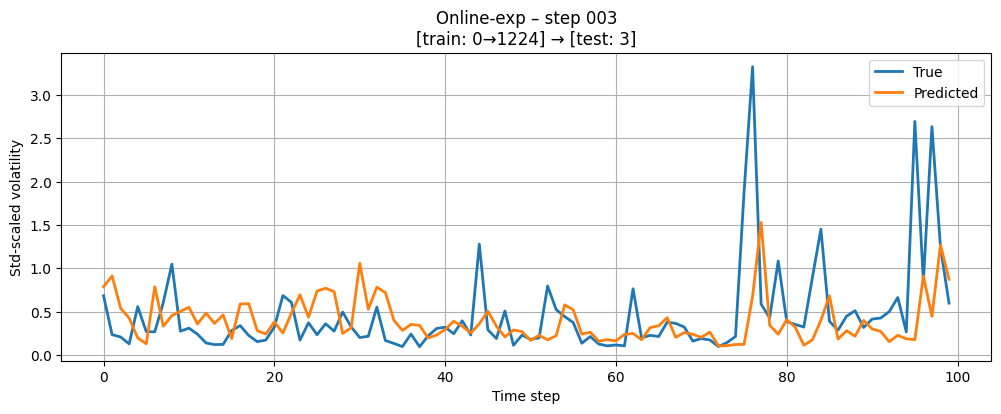

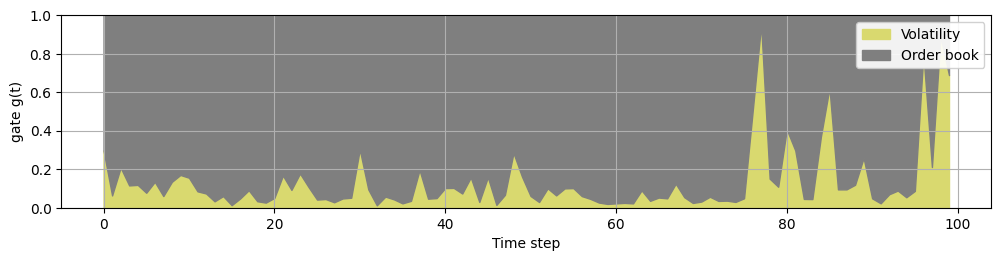

Model saved to saved_models/online_expanding/weibull/model_step_4.pt
Original scale residuals saved to saved_residuals/online_expanding/weibull/original_residuals_step_4.npy
Predictions saved to saved_predictions/online_expanding/weibull/predictions_step_4.npy


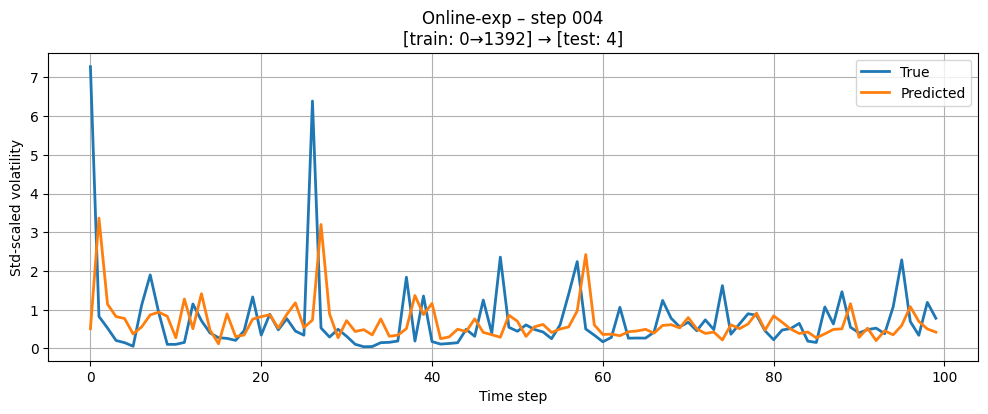

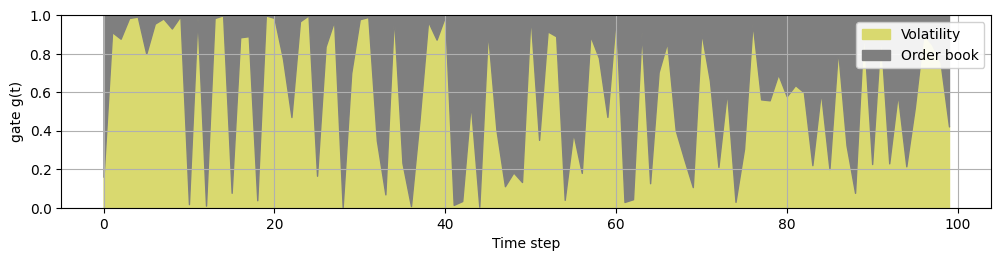

Model saved to saved_models/online_expanding/weibull/model_step_5.pt
Original scale residuals saved to saved_residuals/online_expanding/weibull/original_residuals_step_5.npy
Predictions saved to saved_predictions/online_expanding/weibull/predictions_step_5.npy


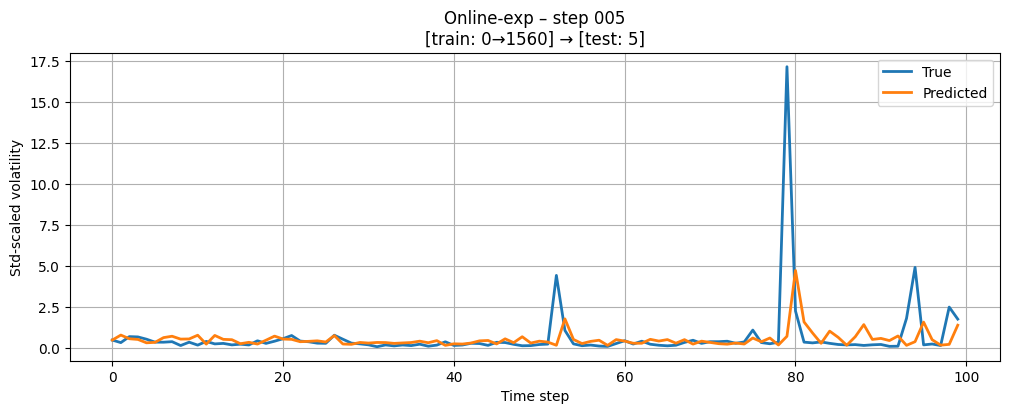

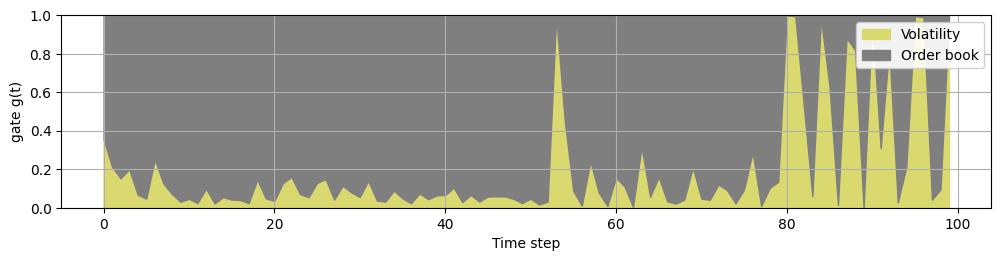

Model saved to saved_models/online_expanding/weibull/model_step_6.pt
Original scale residuals saved to saved_residuals/online_expanding/weibull/original_residuals_step_6.npy
Predictions saved to saved_predictions/online_expanding/weibull/predictions_step_6.npy


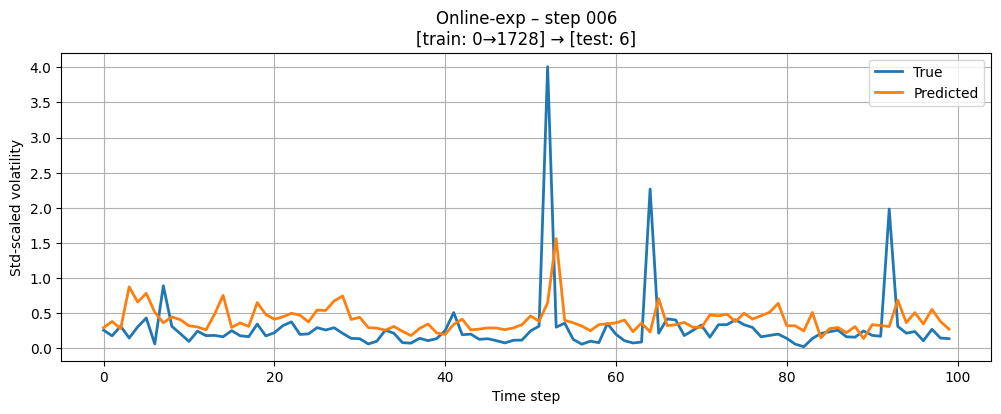

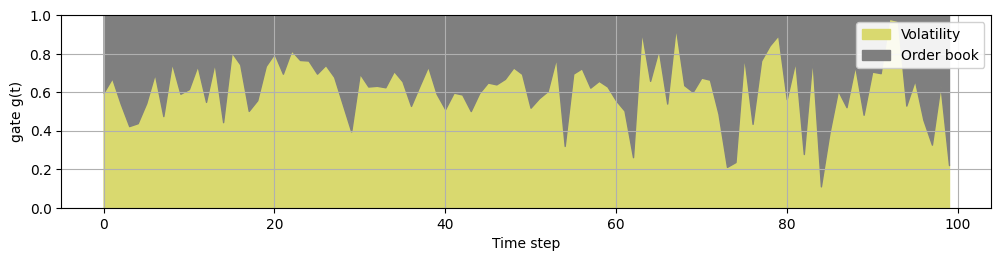

Model saved to saved_models/online_expanding/weibull/model_step_7.pt
Original scale residuals saved to saved_residuals/online_expanding/weibull/original_residuals_step_7.npy
Predictions saved to saved_predictions/online_expanding/weibull/predictions_step_7.npy


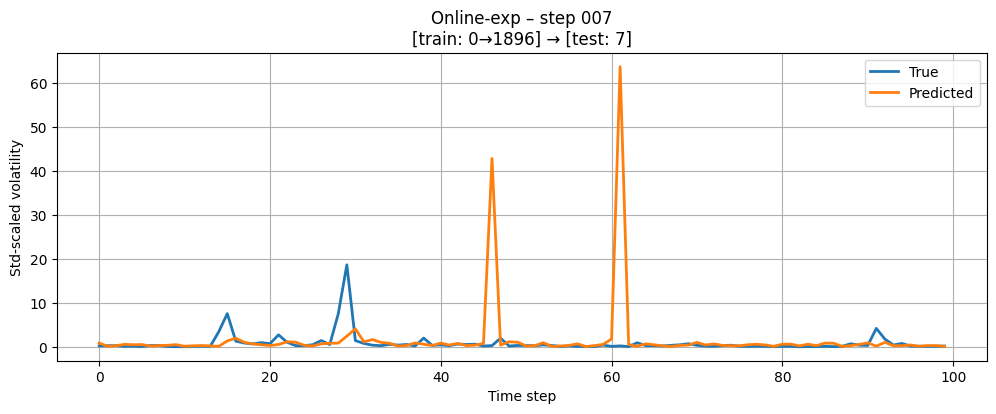

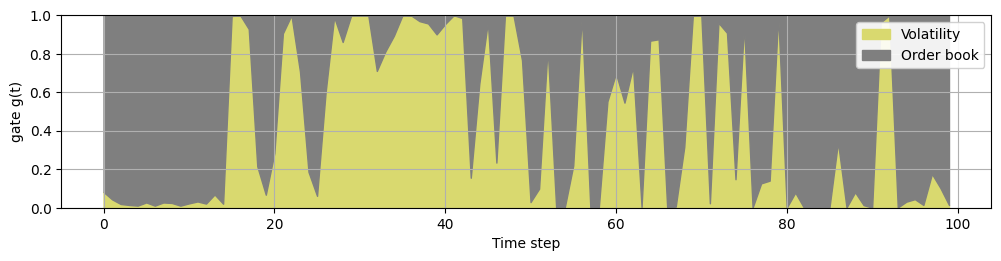

Model saved to saved_models/online_expanding/weibull/model_step_8.pt
Original scale residuals saved to saved_residuals/online_expanding/weibull/original_residuals_step_8.npy
Predictions saved to saved_predictions/online_expanding/weibull/predictions_step_8.npy


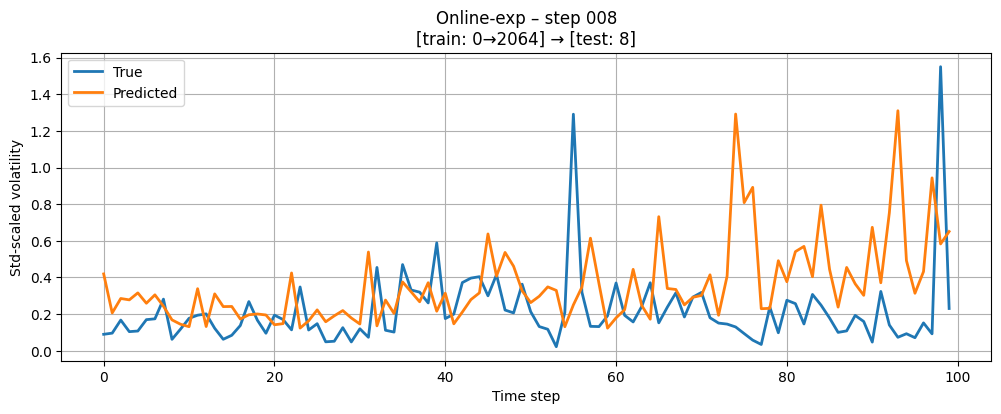

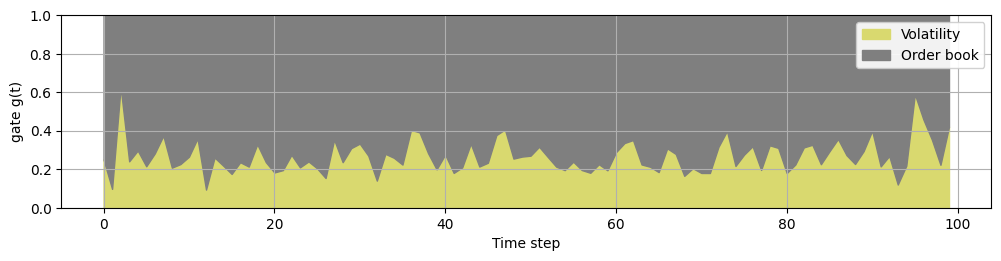

Model saved to saved_models/online_expanding/weibull/model_step_9.pt
Original scale residuals saved to saved_residuals/online_expanding/weibull/original_residuals_step_9.npy
Predictions saved to saved_predictions/online_expanding/weibull/predictions_step_9.npy


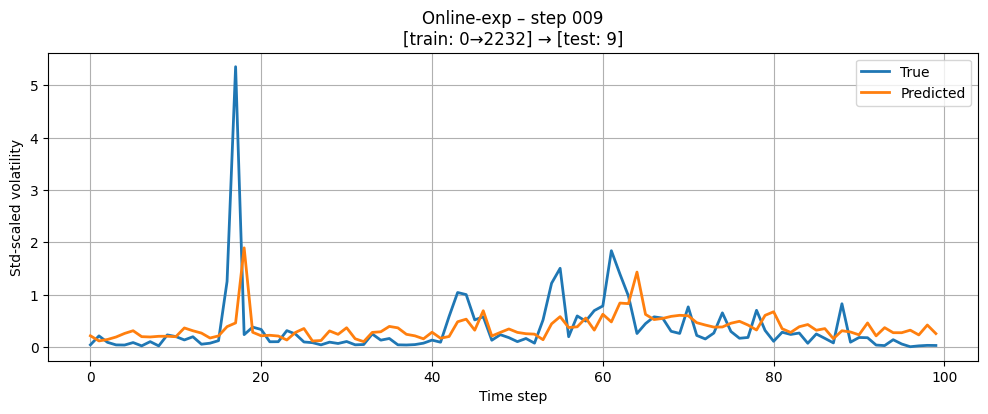

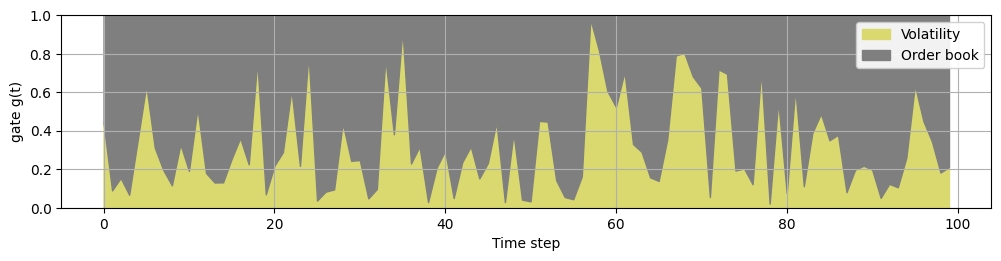

[online-exp] finished 10 steps.

=== Training model: HINGE_WEIBULL ===

Model saved to saved_models/online_expanding/hinge_weibull/model_step_0.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge_weibull/original_residuals_step_0.npy
Predictions saved to saved_predictions/online_expanding/hinge_weibull/predictions_step_0.npy


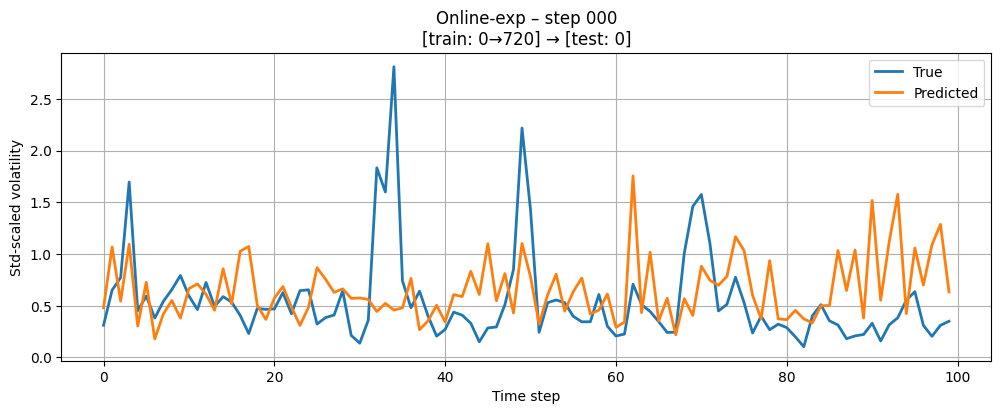

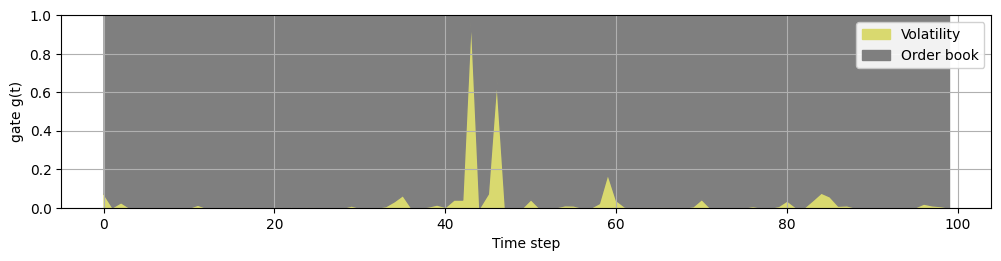

Model saved to saved_models/online_expanding/hinge_weibull/model_step_1.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge_weibull/original_residuals_step_1.npy
Predictions saved to saved_predictions/online_expanding/hinge_weibull/predictions_step_1.npy


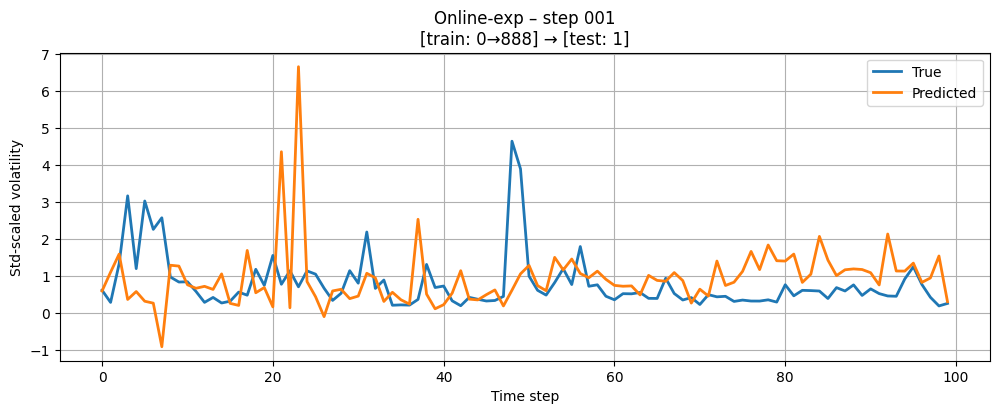

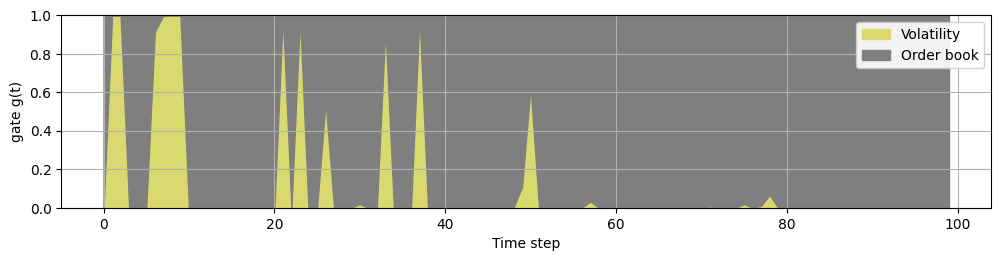

Model saved to saved_models/online_expanding/hinge_weibull/model_step_2.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge_weibull/original_residuals_step_2.npy
Predictions saved to saved_predictions/online_expanding/hinge_weibull/predictions_step_2.npy


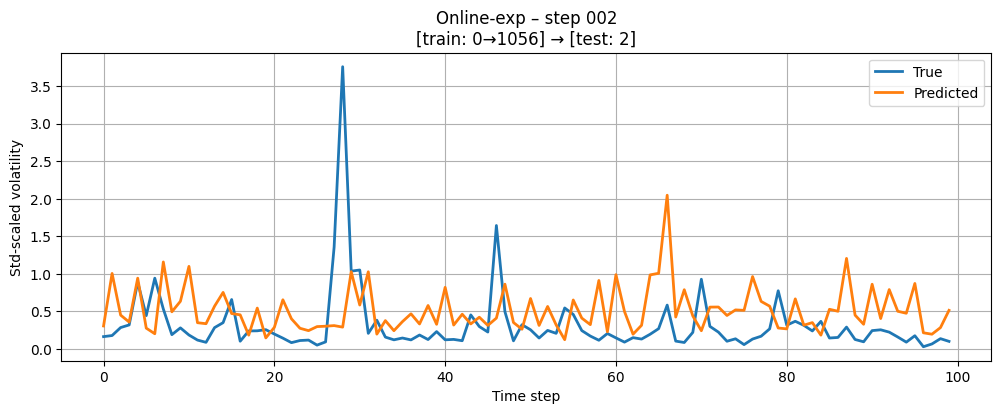

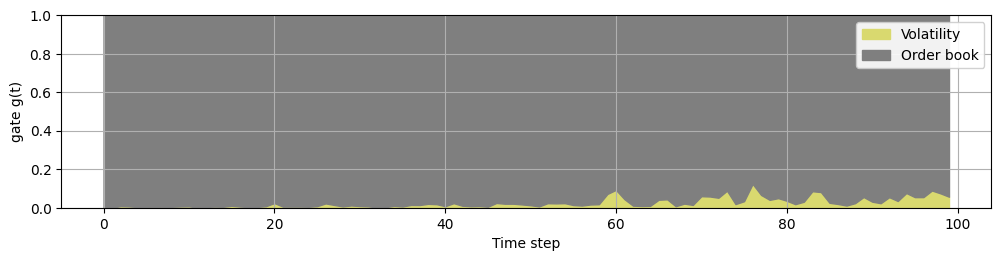

Model saved to saved_models/online_expanding/hinge_weibull/model_step_3.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge_weibull/original_residuals_step_3.npy
Predictions saved to saved_predictions/online_expanding/hinge_weibull/predictions_step_3.npy


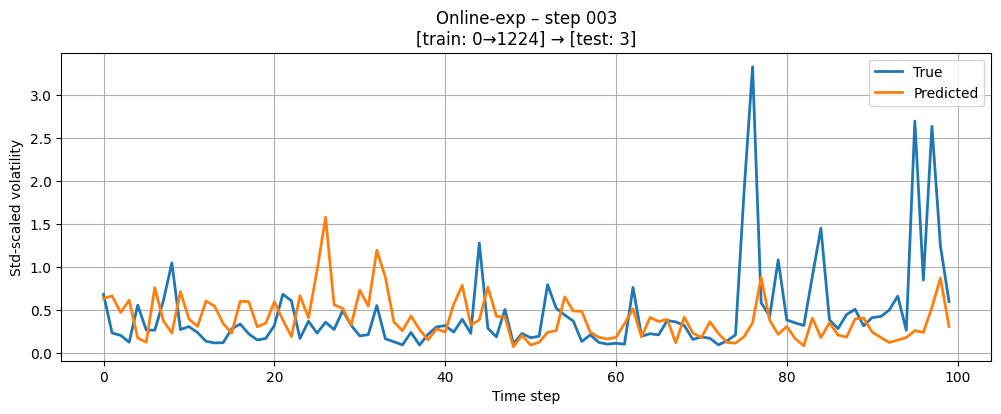

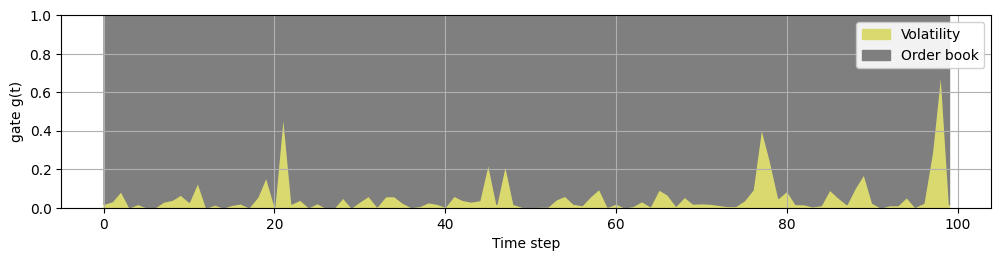

Model saved to saved_models/online_expanding/hinge_weibull/model_step_4.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge_weibull/original_residuals_step_4.npy
Predictions saved to saved_predictions/online_expanding/hinge_weibull/predictions_step_4.npy


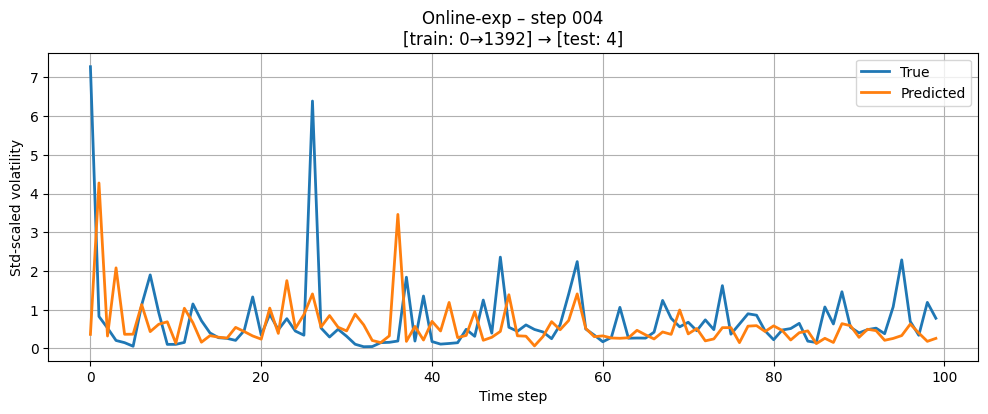

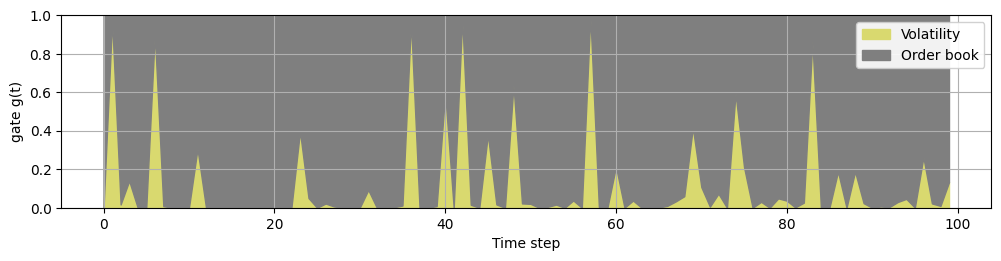

Model saved to saved_models/online_expanding/hinge_weibull/model_step_5.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge_weibull/original_residuals_step_5.npy
Predictions saved to saved_predictions/online_expanding/hinge_weibull/predictions_step_5.npy


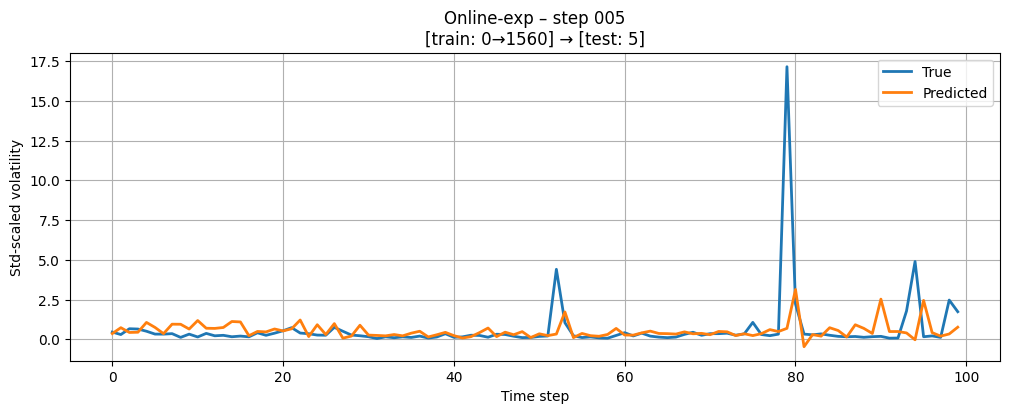

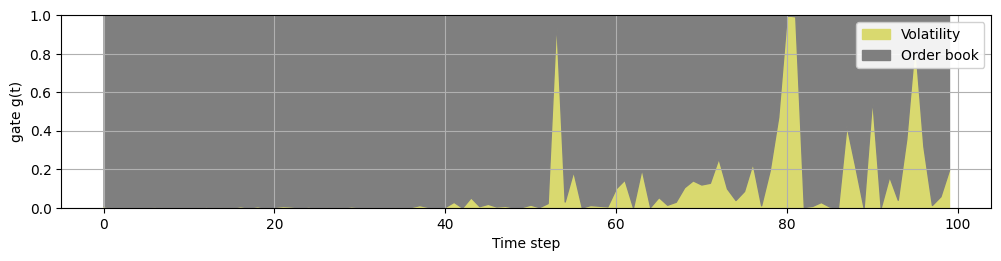

Model saved to saved_models/online_expanding/hinge_weibull/model_step_6.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge_weibull/original_residuals_step_6.npy
Predictions saved to saved_predictions/online_expanding/hinge_weibull/predictions_step_6.npy


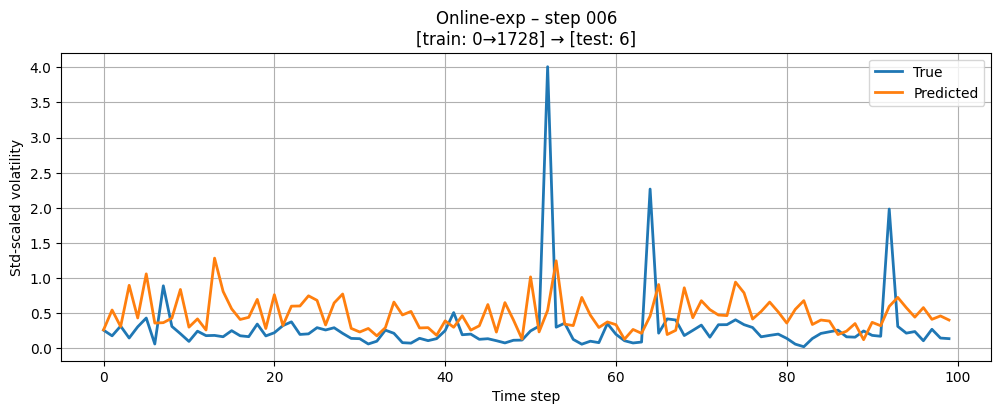

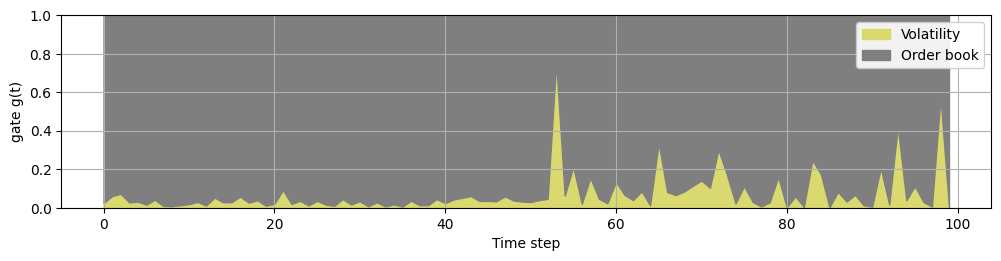

Model saved to saved_models/online_expanding/hinge_weibull/model_step_7.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge_weibull/original_residuals_step_7.npy
Predictions saved to saved_predictions/online_expanding/hinge_weibull/predictions_step_7.npy


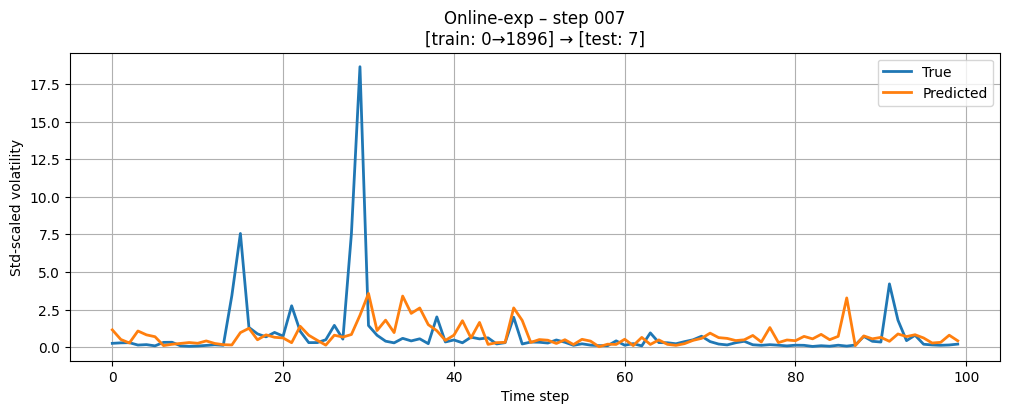

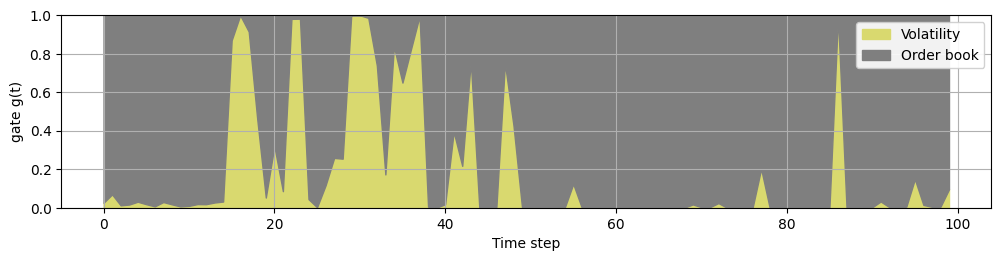

Model saved to saved_models/online_expanding/hinge_weibull/model_step_8.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge_weibull/original_residuals_step_8.npy
Predictions saved to saved_predictions/online_expanding/hinge_weibull/predictions_step_8.npy


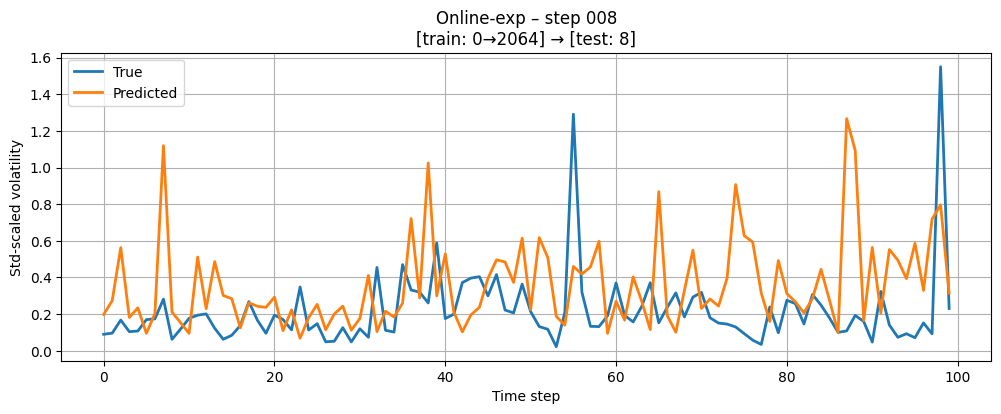

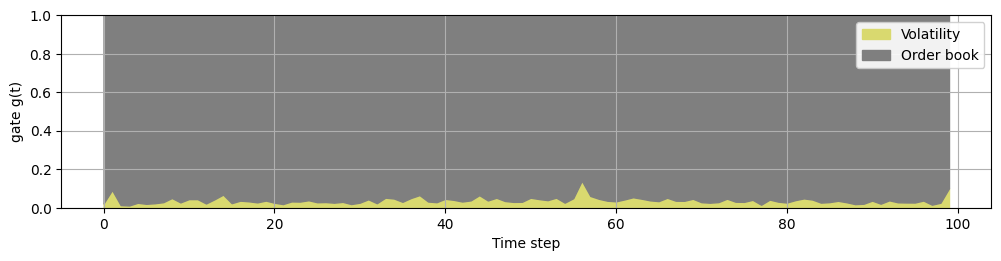

Model saved to saved_models/online_expanding/hinge_weibull/model_step_9.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge_weibull/original_residuals_step_9.npy
Predictions saved to saved_predictions/online_expanding/hinge_weibull/predictions_step_9.npy


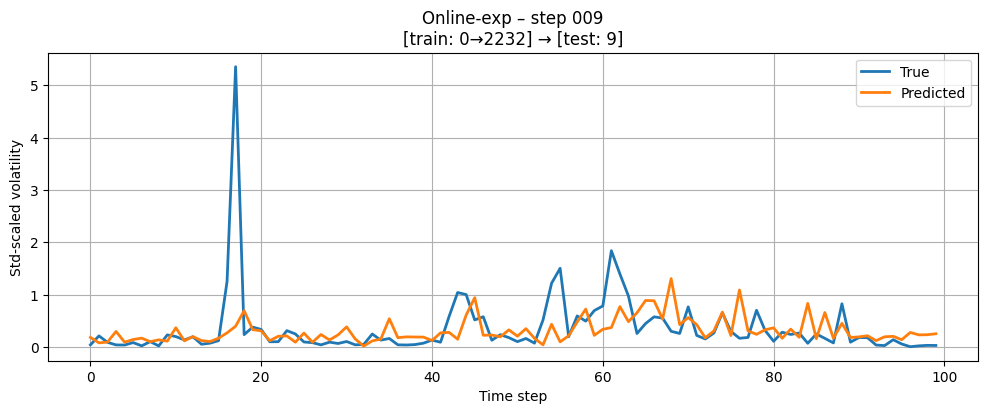

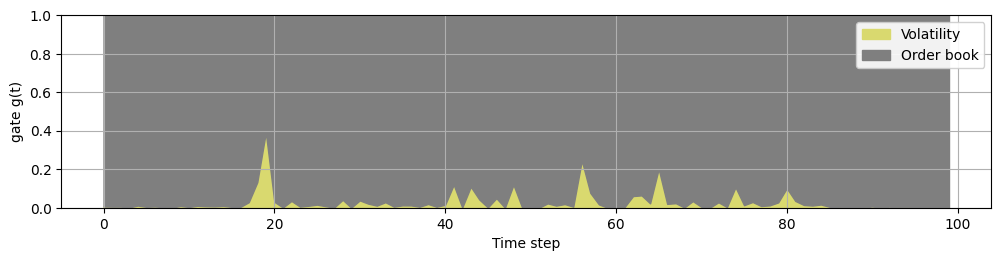

[online-exp] finished 10 steps.

=== Training model: HINGE_INVERSE_GAUSSIAN ===

Model saved to saved_models/online_expanding/hinge_inverse_gaussian/model_step_0.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge_inverse_gaussian/original_residuals_step_0.npy
Predictions saved to saved_predictions/online_expanding/hinge_inverse_gaussian/predictions_step_0.npy


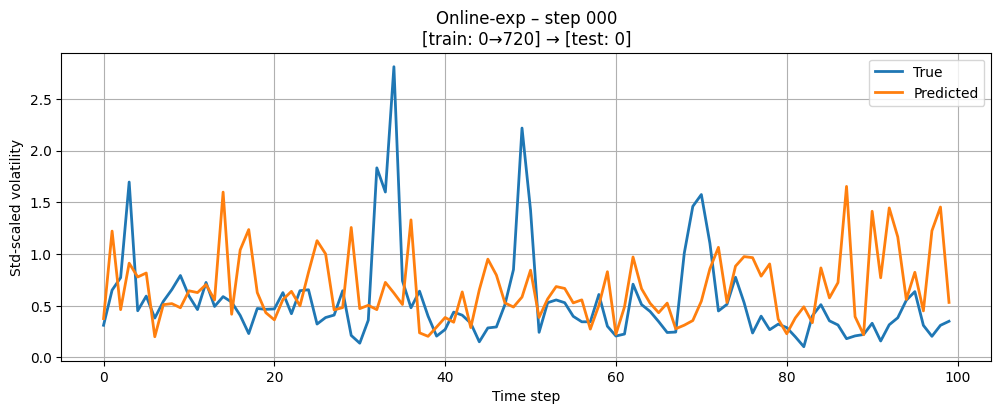

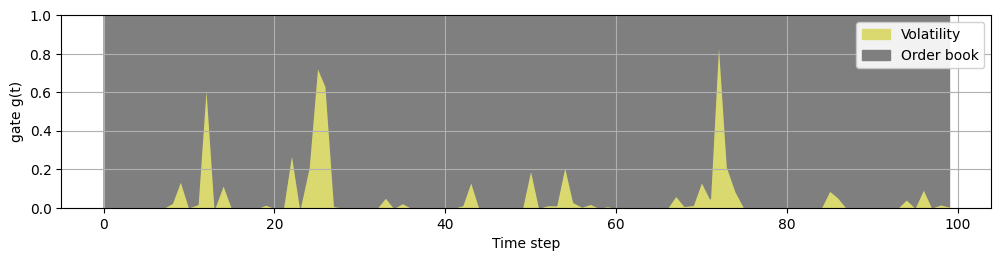

Model saved to saved_models/online_expanding/hinge_inverse_gaussian/model_step_1.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge_inverse_gaussian/original_residuals_step_1.npy
Predictions saved to saved_predictions/online_expanding/hinge_inverse_gaussian/predictions_step_1.npy


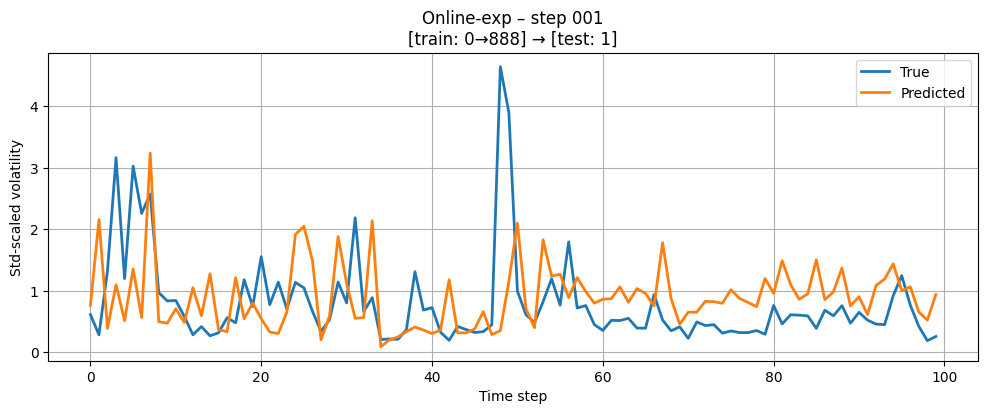

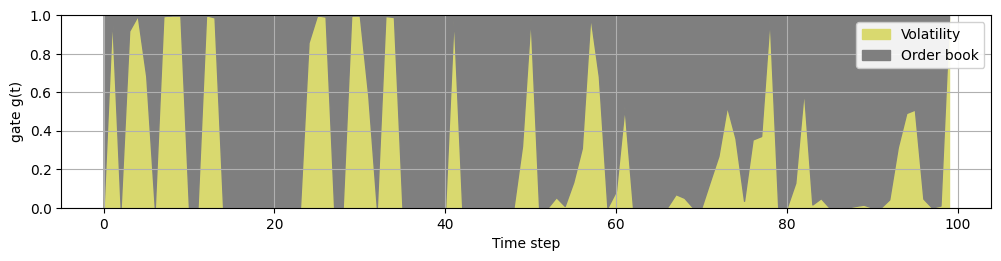

Model saved to saved_models/online_expanding/hinge_inverse_gaussian/model_step_2.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge_inverse_gaussian/original_residuals_step_2.npy
Predictions saved to saved_predictions/online_expanding/hinge_inverse_gaussian/predictions_step_2.npy


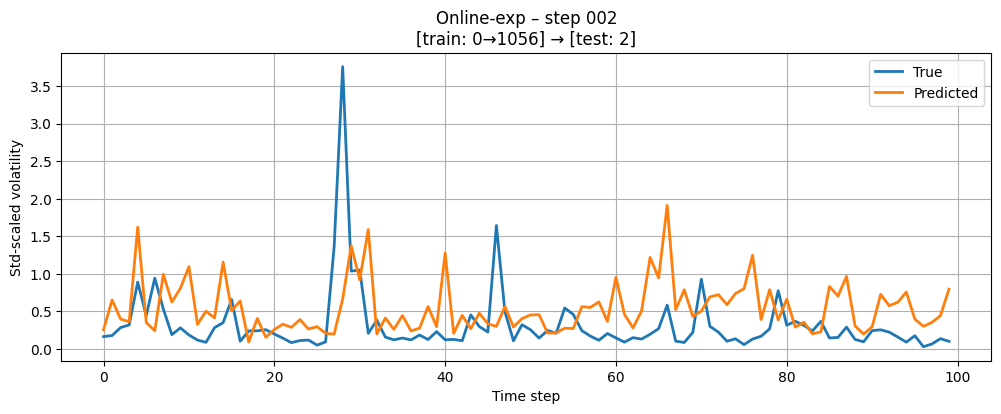

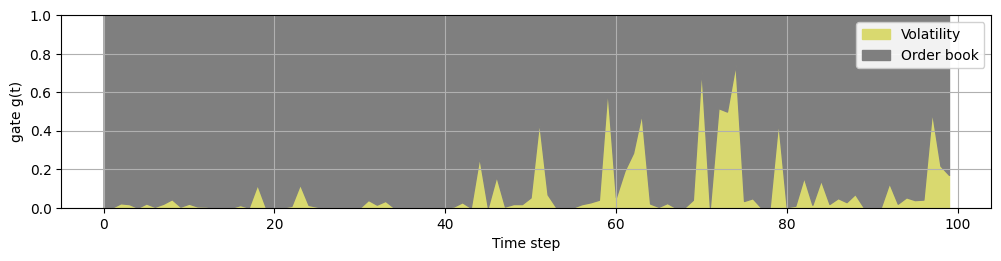

Model saved to saved_models/online_expanding/hinge_inverse_gaussian/model_step_3.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge_inverse_gaussian/original_residuals_step_3.npy
Predictions saved to saved_predictions/online_expanding/hinge_inverse_gaussian/predictions_step_3.npy


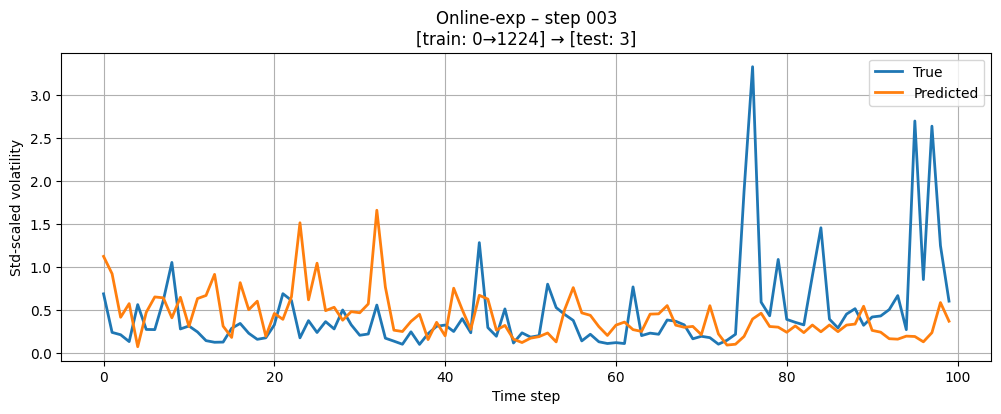

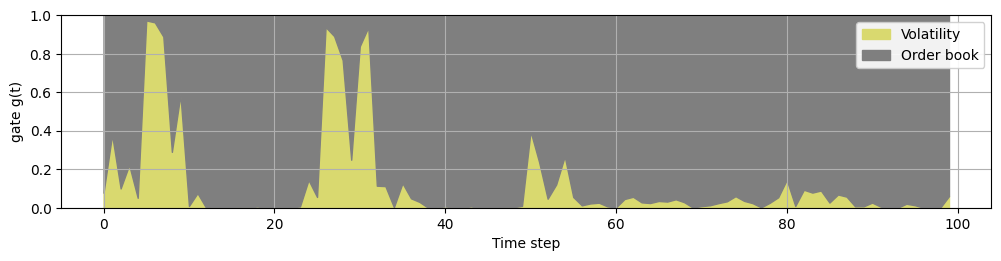

Model saved to saved_models/online_expanding/hinge_inverse_gaussian/model_step_4.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge_inverse_gaussian/original_residuals_step_4.npy
Predictions saved to saved_predictions/online_expanding/hinge_inverse_gaussian/predictions_step_4.npy


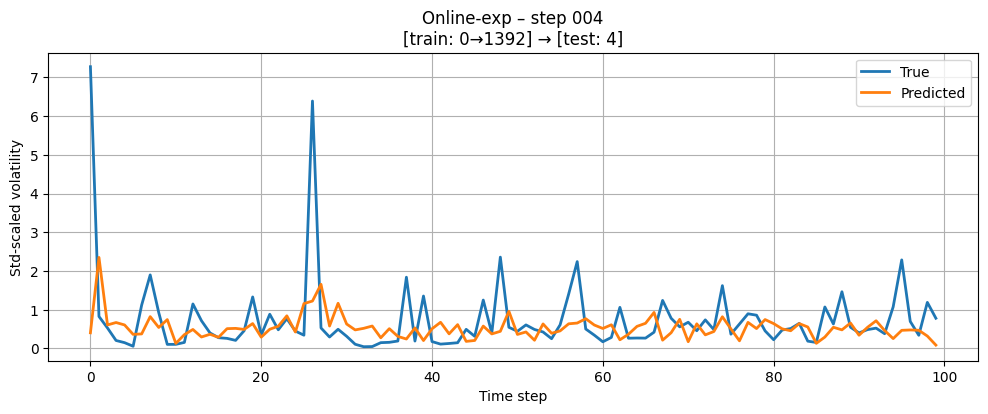

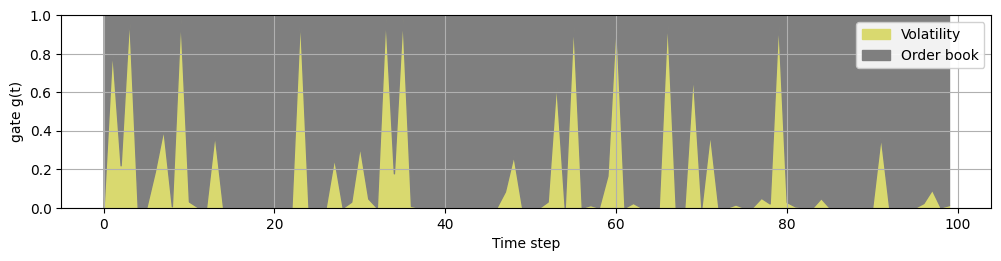

Model saved to saved_models/online_expanding/hinge_inverse_gaussian/model_step_5.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge_inverse_gaussian/original_residuals_step_5.npy
Predictions saved to saved_predictions/online_expanding/hinge_inverse_gaussian/predictions_step_5.npy


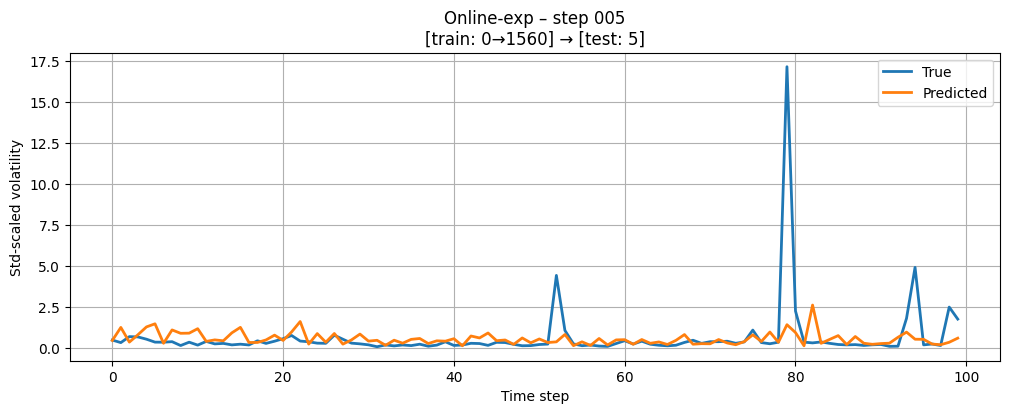

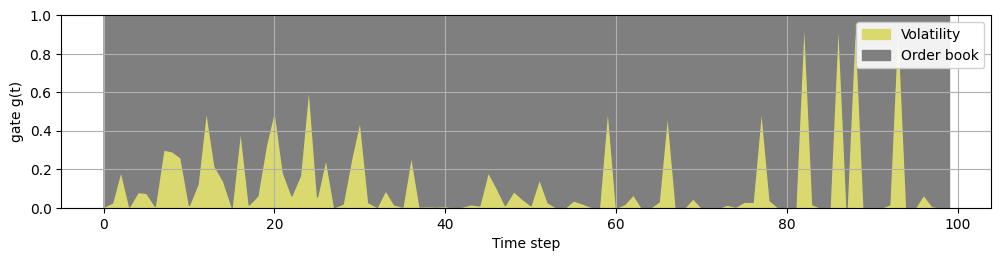

Model saved to saved_models/online_expanding/hinge_inverse_gaussian/model_step_6.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge_inverse_gaussian/original_residuals_step_6.npy
Predictions saved to saved_predictions/online_expanding/hinge_inverse_gaussian/predictions_step_6.npy


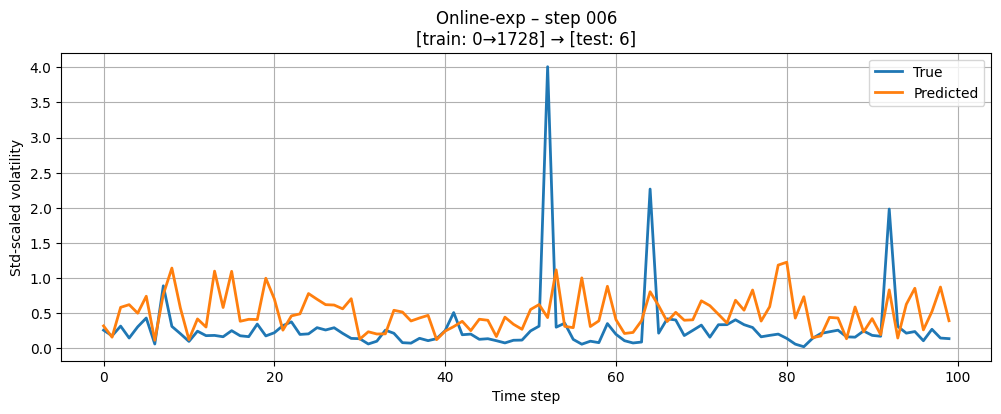

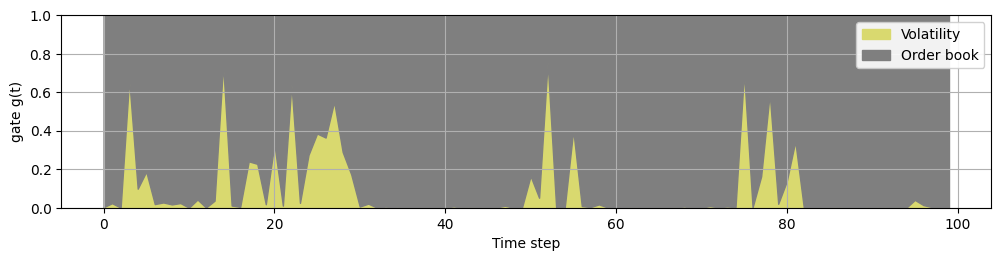

Model saved to saved_models/online_expanding/hinge_inverse_gaussian/model_step_7.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge_inverse_gaussian/original_residuals_step_7.npy
Predictions saved to saved_predictions/online_expanding/hinge_inverse_gaussian/predictions_step_7.npy


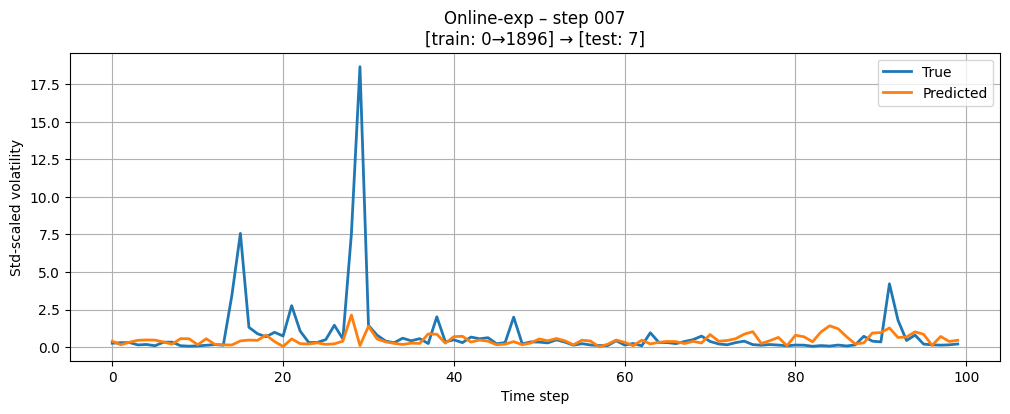

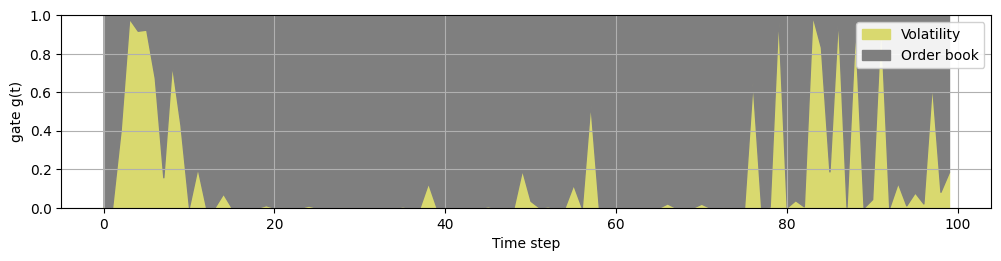

Model saved to saved_models/online_expanding/hinge_inverse_gaussian/model_step_8.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge_inverse_gaussian/original_residuals_step_8.npy
Predictions saved to saved_predictions/online_expanding/hinge_inverse_gaussian/predictions_step_8.npy


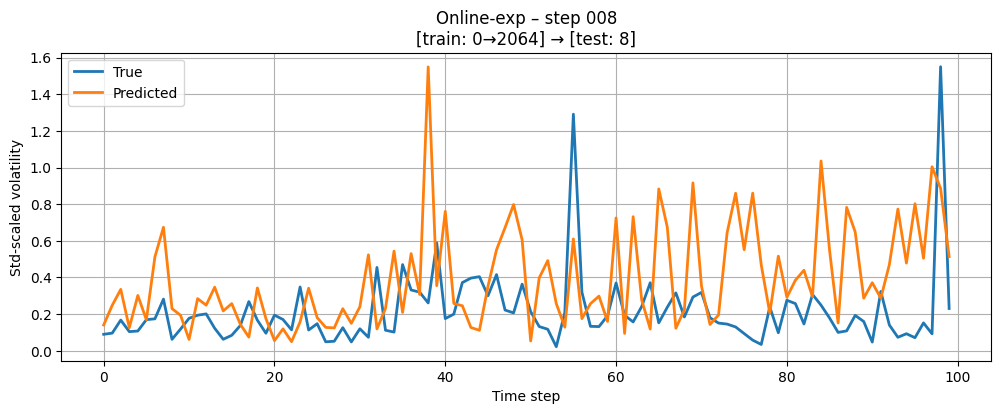

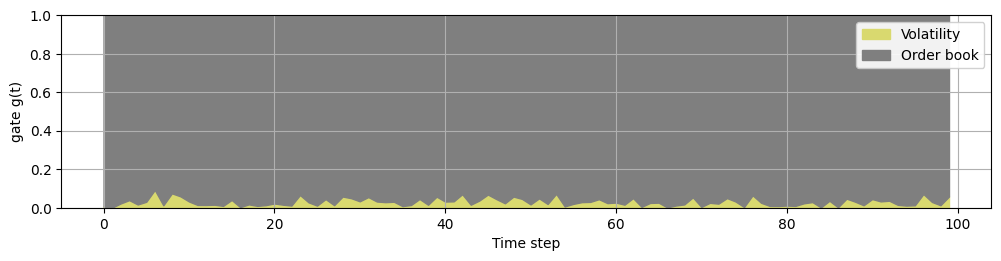

Model saved to saved_models/online_expanding/hinge_inverse_gaussian/model_step_9.pt
Original scale residuals saved to saved_residuals/online_expanding/hinge_inverse_gaussian/original_residuals_step_9.npy
Predictions saved to saved_predictions/online_expanding/hinge_inverse_gaussian/predictions_step_9.npy


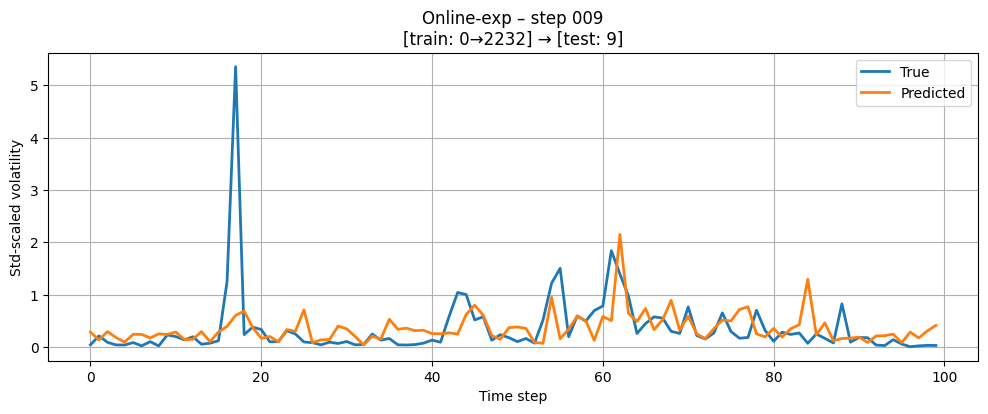

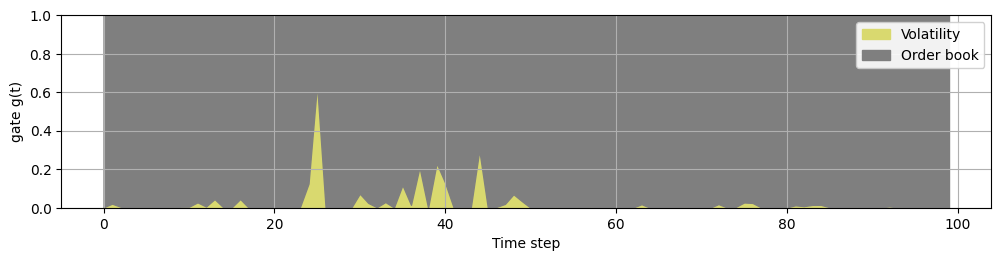

[online-exp] finished 10 steps.


In [29]:
model_list = ["normal", "hinge", "lognormal", "inverse_gaussian", "weibull", "hinge_weibull", "hinge_inverse_gaussian"]
#model_list = ["inverse_gaussian", "weibull", "hinge_weibull", "hinge_inverse_gaussian"]
all_results = {}
all_histories = {}
for model_name in model_list:
        print(f"\n=== Training model: {model_name.upper()} ===\n")
        
        result = results(csv_path="../../data/spx/btc-2/data_df.csv",
                      strategy="online_expanding",
                      lookback_days = 30,        # start with 1 month
                horizon_days  = 7,         # predict 1 week each time
                        stride_days   = 7,  
                      model_type=model_name,
                      ar_order=64,
                      lb=120,
                      lr=0.001,
                      batch=32,
                      epochs=120,
                      penalty_coef=3.0,
                      delta=0.0,
                      kl_weight=0.01,
                      l2_coef=0.01,
                      eps=1e-8,
                      device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                      interval_hours=720,
                      back_intervals=2,
                      return_history=True,
                      do_plot=True)
        
        all_results[model_name] = result
        

In [28]:
all_histories = all_results
rmse_table  : dict[str, pd.Series] = {}
mae_table   : dict[str, pd.Series] = {}
sigma_table : dict[str, pd.Series] = {}

def _to_series(hist: list[dict], metric: str, default: float = float("nan")):
    """
    Convert a history list to a pandas Series keyed by interval / step.
    Falls back to RangeIndex if neither 'interval' nor 'step' exists.
    """
    if not hist:                              # empty list → empty Series
        return pd.Series(dtype=float)

    # detect the index key in the first record
    first = hist[0]
    if "interval" in first:
        idx_key = "interval"
    elif "step" in first:
        idx_key = "step"
    else:
        idx_key = None

    if idx_key:
        data = {rec[idx_key]: rec.get(metric, default) for rec in hist}
        return pd.Series(data, name=metric).sort_index()
    else:
        # Default sequential index
        data = [rec.get(metric, default) for rec in hist]
        return pd.Series(data, index=range(len(hist)), name=metric)


for model_name, hist in all_histories.items():
    rmse_table[model_name]  = _to_series(hist, "rmse")
    mae_table[model_name]   = _to_series(hist, "mae")
    sigma_table[model_name] = _to_series(hist, "sigma_vol", default=1.0)

# ----------------------------- align & reindex ------------------------------
rmse_df   = pd.DataFrame(rmse_table).T
mae_df    = pd.DataFrame(mae_table).T
sigma_df  = pd.DataFrame(sigma_table).T.fillna(1.0)   # missing sigmas → 1.0

# ensure identical column order across dfs
all_cols = sorted(set(rmse_df.columns) |
                  set(mae_df.columns)  |
                  set(sigma_df.columns))
rmse_df   = rmse_df.reindex(columns=all_cols)
mae_df    = mae_df.reindex(columns=all_cols)
sigma_df  = sigma_df.reindex(columns=all_cols).fillna(1.0)

# ----------------------------- unscale --------------------------------------
rmse_unscaled = rmse_df * sigma_df
mae_unscaled  = mae_df  * sigma_df

rmse_unscaled.loc["best"] = rmse_unscaled.idxmin(axis=0)
mae_unscaled.loc["best"]  = mae_unscaled.idxmin(axis=0)

combined = (
    pd.concat({"RMSE": rmse_unscaled, "MAE": mae_unscaled}, axis=1)
      .reorder_levels([0, 1], axis=1)
      .sort_index(axis=1, level=0)
)

display(combined)

MAE                                             \
                               0                      1         2         3   
normal                  0.000054               0.000106  0.000059  0.000067   
hinge                   0.000054               0.000099  0.000064  0.000068   
lognormal               0.000089  20071814072288.808594  0.000111   0.00008   
inverse_gaussian        0.000065               0.000112  0.000088  0.000092   
weibull                 0.000071                0.00012  0.000099  0.000087   
hinge_weibull           0.000074               0.000115  0.000093  0.000083   
hinge_inverse_gaussian  0.000085               0.000127  0.000104  0.000091   
best                      normal                  hinge    normal    normal   

                                                              \
                                       4         5         6   
normal                           0.00013  0.000155  0.000052   
hinge                           0.000134  0.000124  0.000083   
lognormal                       0.000164  0.000151  0.000103   
inverse_gaussian                0.000116  0.000151   0.00008   
weibull                         0.000121  0.000134  0.000066   
hinge_weibull                   0.000117  0.000142  0.000068   
hinge_inverse_gaussian           0.00012  0.000137  0.000073   
best                    inverse_gaussian     hinge    normal   

                                                                              \
                                             7              8              9   
normal                                0.000208       0.000057       0.000074   
hinge                                 0.000185       0.000058       0.000069   
lognormal                             0.000219       0.000089       0.000082   
inverse_gaussian                      0.000185       0.000061       0.000073   
weibull                               0.000173       0.000055       0.000072   
hinge_weibull                         0.000175       0.000045       0.000069   
hinge_inverse_gaussian                0.000161       0.000049       0.000072   
best                    hinge_inverse_gaussian  hinge_weibull  hinge_weibull   

                            RMSE                                             \
                               0                      1         2         3   
normal                  0.000081               0.000172  0.000107  0.000121   
hinge                   0.000082               0.000166  0.000109   0.00012   
lognormal               0.000108  204684227770756.65625  0.000135   0.00012   
inverse_gaussian        0.000088               0.000184  0.000117  0.000129   
weibull                 0.000105               0.000181  0.000146  0.000143   
hinge_weibull           0.000107               0.000178  0.000147  0.000139   
hinge_inverse_gaussian  0.000118               0.000189  0.000157   0.00015   
best                      normal                  hinge    normal     hinge   

                                                                    \
                               4                       5         6   
normal                  0.000229                0.000442  0.000122   
hinge                   0.000237                0.000427  0.000133   
lognormal               0.000283                0.000432   0.00017   
inverse_gaussian        0.000239                0.000434   0.00013   
weibull                 0.000249                0.000433  0.000131   
hinge_weibull           0.000246                0.000435  0.000132   
hinge_inverse_gaussian  0.000246                0.000422  0.000131   
best                      normal  hinge_inverse_gaussian    normal   

                                                                   
                                       7              8         9  
normal                          0.000539       0.000069  0.000154  
hinge                           0.000505        0.00007  0.000149  
lognormal                       